In [1]:
import os
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.8'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
import jax
import flax
import jax.numpy as jnp
import flax.linen as nn
import wandb
#from flax.training import checkpoints
#import optax

import time
from functools import partial

import numpy as np
from matplotlib import pyplot as plt

print('Jax version', jax.__version__)
print('Flax version', flax.__version__)
random_key = jax.random.PRNGKey(0)

Jax version 0.3.25
Flax version 0.5.1


2023-03-13 11:27:26.507309: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/nvptx_compiler.cc:497] The NVIDIA driver's CUDA version is 11.7 which is older than the ptxas CUDA version (12.0.76). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
! wandb login

In [2]:
wandb.init(project="brain", entity="glow-jax")
config = wandb.config
config.batch_size = 128
config.learning_rate = 1e-3
config.epochs = 100

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: youngbinkoko (glow-jax). Use `wandb login --relogin` to force relogin


# Data

In [3]:
import glob
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#   tf.config.experimental.set_memory_growth(gpu, True)
import tensorflow_datasets as tfds
# tf.config.experimental.set_visible_devices([], 'GPU')
import matplotlib.pyplot as plt
import einops
#from torch.utils.data.dataset import Dataset
#from torch.utils.data import DataLoader
from pathlib import Path

/dhc/home/youngbin.ko/conda3/envs/exp_glow/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def map_fn(image, num_bits=5, size=256, training=True):
    """Transform the image data and quantize.
    If num_bits = 8, there is no quantization effect."""
    # Resize input image
    image = tf.cast(image, tf.float32)
    # tf.make_ndarray(image)
    image = tf.image.resize(image, (size, size))
    image = tf.clip_by_value(image, 0., 255.)
    # Discretize to the given number of bits
    if num_bits < 8:
        image = tf.floor(image / 2 ** (8 - num_bits))
    # Send to [-1, 1]
    num_bins = 2 ** num_bits
    image = image / num_bins - 0.5
    if training:
        image = image + tf.random.uniform(tf.shape(image), 0, 1. / num_bins)
    return image


In [ ]:
def get_train_dataset(image_path, image_size, num_bits, batch_size, **kwargs):
    del kwargs
    empty_tensor = tf.constant([], dtype=tf.float32)
    train_ds = tf.data.Dataset.from_tensor_slices(empty_tensor)
    file_paths = glob.glob(f"{image_path}/*.npy")
    print(file_paths)
    np.random.shuffle(file_paths)
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        slices_path = os.path.join('/dhc/home/youngbin.ko/glow_brain/data/slices_train_new_64', f'{filename.split(".")[0]}_slices.npy')
        # if os.path.exists(slices_path):
        #         # If slices already exist, load and concatenate them to the train_ds
        #         slices = np.load(slices_path)
        #         slices_dataset = tf.data.Dataset.from_tensor_slices(slices)
        #         train_ds = train_ds.concatenate(slices_dataset)
        # else:
            # If slices do not exist, generate them and save them to slices_path
        slices_dataset = generate_slices_npy(file_path, image_size, num_bits, True)
        train_ds = train_ds.concatenate(slices_dataset)

    num_elements = train_ds.cardinality().numpy()
    print("Number of elements in train_ds:", num_elements/155)    
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.repeat()
    return iter(tfds.as_numpy(train_ds))

# to save slices in .npy format
def generate_slices_npy(file_path, image_size, num_bits, training):
    img = np.load(file_path)
    dir_path, filename = os.path.split(file_path)
    if img.shape[0] == 0:
        return tf.data.Dataset.from_tensor_slices([])
    img = einops.rearrange(img, 'm h w s -> s h w m')
    slices = []
    for slice in range(img.shape[0]):
        slices.append(img[slice, :, :, :])
    slices_dataset = tf.data.Dataset.from_tensor_slices(slices)
    slices_ds = slices_dataset.map(partial(map_fn, size=image_size, num_bits=num_bits, training=training))
    # output_dir = os.path.join(dir_path, 'slices')
    # os.makedirs(output_dir, exist_ok=True)
    #output_path = os.path.join('/dhc/home/youngbin.ko/glow_brain/data/slices_train_64', f'{filename.split(".")[0]}_slices.npy')
    output_path = os.path.join('/dhc/home/youngbin.ko/glow_brain/data/slices_train_new_64', f'{filename.split(".")[0]}_slices.npy')
    slices_array = np.array(list(slices_ds.as_numpy_iterator()))
    np.save(output_path, slices_array)

    return slices_ds

In [4]:
#after creating slices.npy use this function
def get_train_dataset(image_path, image_size, num_bits, batch_size, **kwargs):
    del kwargs
    empty_tensor = tf.constant([], dtype=tf.float32)
    train_ds = tf.data.Dataset.from_tensor_slices(empty_tensor)
    file_paths = glob.glob(f"{image_path}/*.npy")
    np.random.shuffle(file_paths)
    #train_file_paths = file_paths[:200]
    for file_path in file_paths:
        slices = np.load(file_path)
        slices_dataset = tf.data.Dataset.from_tensor_slices(slices)
        train_ds = train_ds.concatenate(slices_dataset)
    ds_list = list(train_ds)
    np.random.shuffle(ds_list)
    train_ds = tf.data.Dataset.from_tensor_slices(ds_list)
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.repeat()
    num_elements = train_ds.cardinality().numpy()
    print("Number of elements in train_ds:", num_elements)
    return iter(tfds.as_numpy(train_ds))

def get_val_dataset(image_path, image_size, num_bits, batch_size, **kwargs):
    del kwargs
    empty_tensor = tf.constant([], dtype=tf.float32)
    valid_ds = tf.data.Dataset.from_tensor_slices(empty_tensor)
    file_paths = glob.glob(f"{image_path}/*.npy")

    for file_path in file_paths:
        slices = np.load(file_path)
        slices_dataset = tf.data.Dataset.from_tensor_slices(slices)
        valid_ds = valid_ds.concatenate(slices_dataset)
    valid_ds = valid_ds.batch(batch_size)
    valid_ds = valid_ds.repeat()
    num_elements = valid_ds.cardinality().numpy()
    print("Number of elements in valid_ds:", num_elements)
    return iter(tfds.as_numpy(valid_ds))

In [11]:
def get_gp_train_dataset(image_path, image_size, num_bits, batch_size, **kwargs):
    del kwargs
    empty_tensor = tf.constant([], dtype=tf.float32)
    train_ds = tf.data.Dataset.from_tensor_slices(empty_tensor)
    file_paths = glob.glob(f"{image_path}/*.npy")
    for file_path in file_paths:
        slices = np.load(file_path)
        slices_dataset = tf.data.Dataset.from_tensor_slices(slices)
        train_ds = train_ds.concatenate(slices_dataset)
    ds_list = list(train_ds)
    train_ds = tf.data.Dataset.from_tensor_slices(ds_list)
    train_ds = train_ds.batch(batch_size)
    #train_ds = train_ds.repeat()
    num_elements = train_ds.cardinality().numpy()
    print("Number of elements in train_ds:", num_elements)
    return iter(tfds.as_numpy(train_ds))

In [41]:
gp_dataset = get_gp_train_dataset('/dhc/home/youngbin.ko/glow_brain/data_gp/slices_64_new', 64, 8, 155)

Number of elements in train_ds: 120


In [5]:
train_dataset = get_train_dataset('/dhc/home/youngbin.ko/glow_brain/data/slices_train_new_64', 64, 8, 128)
val_dataset = get_val_dataset('/dhc/home/youngbin.ko/glow_brain/data/slices_val_64', 64, 8, 128)

Number of elements in train_ds: -1
Number of elements in valid_ds: -1


In [ ]:
img = next(gp_dataset)
print(img.shape)
plt.imshow(img[105,:, :, :])
plt.show()

In [ ]:
def get_val_dataset(image_path, image_size, num_bits, batch_size, take=None, repeat=False, **kwargs):
    del kwargs
    empty_tensor = tf.constant([], dtype=tf.float32)
    valid_ds = tf.data.Dataset.from_tensor_slices(empty_tensor)
    file_paths = glob.glob(f"{image_path}/*.npy")

    for file_path in file_paths:
        filename = os.path.basename(file_path)
        slices_path = os.path.join('/dhc/home/youngbin.ko/glow_brain/data/slice_val_128', f'{filename.split(".")[0]}_slices.npy')
        slices_dataset = generate_slices_npy(file_path, image_size, num_bits, False)
        valid_ds = valid_ds.concatenate(slices_dataset)

    #val_ds = tf.data.Dataset.from_tensor_slices(slices)
    #valid_ds = valid_ds.map(partial(map_fn, size=image_size, num_bits=num_bits, training=False))
    valid_ds = valid_ds.batch(batch_size)
    if repeat:
        valid_ds = valid_ds.repeat()
    return iter(tfds.as_numpy(valid_ds))

In [ ]:
#train_dataset = get_train_dataset('/dhc/home/youngbin.ko/glow_brain/data/train', 256, 8, 32)
val_dataset = get_val_dataset('/dhc/home/youngbin.ko/glow_brain/data/val', 128, 8, 128)

In [ ]:
img = next(val_dataset)
print(img.shape)
plt.imshow(img[5,:, :, :], cmap='gray')
plt.show()

# Train

In [6]:
from layers import squeeze, unsqueeze
from layers import Split
from layers import ActNorm, Conv1x1, AffineCoupling

from model import FlowStep, GLOW

from utils import summarize_jax_model
from utils import plot_image_grid

In [7]:
@jax.vmap
def get_logpz(z, priors):
    logpz = 0
    for zi, priori in zip(z, priors):
        if priori is None:
            mu = jnp.zeros(zi.shape)
            logsigma = jnp.zeros(zi.shape)
        else:
            mu, logsigma = jnp.split(priori, 2, axis=-1)
        logpz += jnp.sum(- logsigma - 0.5 * jnp.log(2 * jnp.pi) 
                         - 0.5 * (zi - mu) ** 2 / jnp.exp(2 * logsigma))
        # = -0.5 * zi ** 2
    return logpz

# @jax.jit
# def postprocess(x, num_bits):
#     """Map [-0.5, 0.5] quantized images to uint space"""
#     num_bins = 2 ** num_bits
#     x = jnp.floor((x + 0.5) * num_bins)
#     x *= 256. / num_bins

def sample(model, 
           params, 
           eps=None, 
           shape=None, 
           sampling_temperature=1.0, 
           key=jax.random.PRNGKey(10),
           postprocess_fn=None, 
           save_path=None,
           display=True):
    """Sampling only requires a call to the reverse pass of the model"""
    if eps is None:
        zL = jax.random.normal(key, shape) 
    else: 
        zL = eps[-1]
    y, *_ = model.apply(params, zL, eps=eps, sampling_temperature=sampling_temperature, reverse=True)
    if postprocess_fn is not None:
        y = postprocess_fn(y)
    plot_image_grid(y, save_path=save_path, display=display,
                    title=None if save_path is None else save_path.rsplit('.', 1)[0].rsplit('/', 1)[-1])
    return y

In [ ]:
plot_image_grid(next(val_dataset),title="Input data sample")


In [ ]:
def save_model(log_dir, opt, step=0):
    # Save current model at certain training iteration
    checkpoints.save_checkpoint(ckpt_dir=log_dir, target=opt.target, step=step)

# def load_model(self, pretrained=False):
#     # Load model. We use different checkpoint for pretrained models
#     if not pretrained:
#         params = checkpoints.restore_checkpoint(ckpt_dir=self.log_dir, target=self.state.params)
#     else:
#         params = checkpoints.restore_checkpoint(ckpt_dir=os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'), 
#                                                 target=self.state.params)
#     self.state = train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=self.state.tx)

In [8]:
def train_glow(train_ds,
               val_ds=None,
               num_samples=9,
               image_size=64,
               num_channels=4,
               num_bits=8,
               init_lr=1e-3,
               num_epochs=1,
               num_sample_epochs=1,
               num_warmup_epochs=10,
               num_save_epochs=1,
               steps_per_epoch=416,
               K=32,
               L=3,
               nn_width=512,
               sampling_temperature=0.7,
               learn_top_prior=True,
               key=jax.random.PRNGKey(0),
               **kwargs):
    """Simple training loop.
    Args:
        train_ds: Training dataset iterator (e.g. tensorflow dataset) 70%
        val_ds: Validation dataset (optional) 30%
        num_samples: Number of samples to generate at each epoch
        image_size: Input image size
        num_channels: Number of channels in input images
        num_bits: Number of bits for discretization
        init_lr: Initial learning rate (Adam)
        num_epochs: Numer of training epochs
        num_sample_epochs: Visualize sample at this interval
        num_warmup_epochs: Linear warmup of the learning rate to init_lr
        num_save_epochs: save mode at this interval
        steps_per_epochs: Number of steps per epochs
        K: Number of flow iterations in the GLOW model
        L: number of scales in the GLOW model
        nn_width: Layer width in the Affine Coupling Layer
        sampling_temperature: Smoothing temperature for sampling from the 
            Gaussian priors (1 = no effect)
        learn_top_prior: Whether to learn the prior for highest latent variable zL.
            Otherwise, assumes standard unit Gaussian prior
        key: Random seed
    """
    del kwargs
    # Init model
    model = GLOW(K=K,
                 L=L, 
                 nn_width=nn_width, 
                 learn_top_prior=learn_top_prior,
                 key=key)
    
    # Init optimizer and learning rate schedule
    params = model.init(random_key, next(train_ds))
    opt = flax.optim.Adam(learning_rate=init_lr).create(params)
    # opt = optax.chain(
    #     optax.scale_by_adam(),
    #     # params -= learning_rate * (adam(grads) + params * weight_decay),
    #     optax.scale(-init_lr),
    # )
    
    def lr_warmup(step):
        return init_lr * jnp.minimum(1., step / (num_warmup_epochs * steps_per_epoch + 1e-8))
    
    # Helper functions for training
    bits_per_dims_norm = np.log(2.) * num_channels * image_size**2
    @jax.jit
    def get_logpx(z, logdets, priors):
        logpz = get_logpz(z, priors)
        logpz = jnp.mean(logpz) / bits_per_dims_norm        # bits per dimension normalization
        logdets = jnp.mean(logdets) / bits_per_dims_norm
        logpx = logpz + logdets - num_bits                  # num_bits: dequantization factor
        return logpx, logpz, logdets
        
    @jax.jit
    def train_step(opt, batch):
        def loss_fn(params):
            _, z, logdets, priors = model.apply(params, batch, reverse=False)
            logpx, logpz, logdets = get_logpx(z, logdets, priors)
            return - logpx, (logpz, logdets)
        logs, grad = jax.value_and_grad(loss_fn, has_aux=True)(opt.target)
        opt = opt.apply_gradient(grad, learning_rate=lr_warmup(opt.state.step))
        return logs, opt
    
    # Helper functions for evaluation 
    @jax.jit
    def eval_step(params, batch):
        _, z, logdets, priors = model.apply(params, batch, reverse=False)
        return - get_logpx(z, logdets, priors)[0]
    
    # Helper function for sampling from random latent fixed during training for comparison
    eps = []
    if not os.path.exists("samples"): os.makedirs("samples")
    if not os.path.exists("weights"): os.makedirs("weights")
    for i in range(L):
        expected_h = image_size // 2**(i + 1)
        expected_c = num_channels * 2**(i + 1)
        if i == L - 1: expected_c *= 2
        eps.append(jax.random.normal(key, (num_samples, expected_h, expected_h, expected_c)))
    sample_fn = partial(sample, eps=eps, key=key, display=False,
                        sampling_temperature=sampling_temperature)
    
    # Train
    print("Start training...")
    print("Available jax devices:", jax.devices())
    print()
    bits = 0.
    start = time.time()
    try:
        for epoch in range(num_epochs):
            # train
            for i in range(steps_per_epoch):
                batch = next(train_ds)
                loss, opt = train_step(opt, batch)
                print(f"\r\033[92m[Epoch {epoch + 1}/{num_epochs}]\033[0m"
                      f"\033[93m[Batch {i + 1}/{steps_per_epoch}]\033[0m"
                      f" loss = {loss[0]:.5f},"
                      f" (log(p(z)) = {loss[1][0]:.5f},"
                      f" logdet = {loss[1][1]:.5f})", end='')
                if np.isnan(loss[0]):
                    print("\nModel diverged - NaN loss")
                    return None, None
                
                step = epoch * steps_per_epoch + i + 1
                if step % int(num_sample_epochs * steps_per_epoch) == 0:
                    sample_fn(model, opt.target, 
                              save_path=f"samples/step_{step:05d}.png")
                    # print(opt.target)
                    # print(type(opt.target))
                    # wandb.log({
                    #     "image": wandb.Image(sample_fn)
                    # }, step=step)

            # eval on one batch of validation samples 
            # + generate random sample
            t = time.time() - start
            if val_ds is not None:
                bits = eval_step(opt.target, next(val_ds))
            print(f"\r\033[92m[Epoch {epoch + 1}/{num_epochs}]\033[0m"
                  f"[{int(t // 3600):02d}h {int((t % 3600) // 60):02d}mn]"
                  f" train_bits/dims = {loss[0]:.3f},"
                  f" val_bits/dims = {bits:.3f}" + " " * 50)
            
            # Save parameters
            log_dir = os.path.join("/dhc/home/youngbin.ko/glow_brain/model/weights", "GLOW-JAX")
            # save_model(log_dir,opt,epoch)
            if (epoch + 1) % num_save_epochs == 0 or epoch == num_epochs - 1:
                with open(f'weights/model_epoch={epoch + 1:03d}.weights', 'wb') as f:
                    f.write(flax.serialization.to_bytes(opt.target))
                    

            wandb.log({
                "Train Loss": loss[0],
                "Validation Loss": bits,
            }, step=epoch)

            # for name, value in opt.target.items():
            #     wandb.log({name: value})
            
    except KeyboardInterrupt:
        print(f"\nInterrupted by user at epoch {epoch + 1}")
        
    # returns final model and parameters
    return model, opt.target

In [9]:
config_dict = {
    'image_size': 64,
    'num_channels': 4,
    'num_bits': 8,
    'batch_size': 128,
    'K': 16,
    'L': 3,
    'nn_width': 512, 
    'learn_top_prior': True,
    'sampling_temperature': 0.7,
    'init_lr': 1e-4,
    'num_epochs': 100,
    'num_warmup_epochs': 1,
    'num_sample_epochs': 0.2, # Fractional epochs for sampling because one epoch is quite long 
    'num_save_epochs': 10,
    'key':jax.random.PRNGKey(10)
}

output_hw = config_dict["image_size"] // 2 ** config_dict["L"]
output_c = config_dict["num_channels"] * 4**config_dict["L"] // 2**(config_dict["L"] - 1)
config_dict["sampling_shape"] = (output_hw, output_hw, output_c)

In [ ]:
image_path="/dhc/home/youngbin.ko/glow_brain/data/slices_train_64"
num_images = len(glob.glob(f"{image_path}/*.npy"))*155
config_dict['steps_per_epoch'] = num_images // config_dict['batch_size']
print(f"{num_images} training images")
print(f"{config_dict['steps_per_epoch']} training steps per epoch")

In [10]:
model, params = train_glow(train_dataset, val_ds=val_dataset, **config_dict)
#model, params = train_glow(train_dataset, **config_dict)

/dhc/home/youngbin.ko/conda3/envs/exp_glow/lib/python3.10/site-packages/flax/optim/base.py:49: DeprecationWarning: Use `optax` instead of `flax.optim`. Refer to the update guide https://flax.readthedocs.io/en/latest/howtos/optax_update_guide.html for detailed instructions.
  warnings.warn(


Start training...
Available jax devices: [StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]



/dhc/home/youngbin.ko/conda3/envs/exp_glow/lib/python3.10/site-packages/flax/core/scope.py:740: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  abs_value_flat = jax.tree_leaves(abs_value)
/dhc/home/youngbin.ko/conda3/envs/exp_glow/lib/python3.10/site-packages/flax/core/scope.py:741: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  value_flat = jax.tree_leaves(value)
/dhc/home/youngbin.ko/conda3/envs/exp_glow/lib/python3.10/site-packages/flax/optim/base.py:90: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  params_flat, treedef = jax.tree_flatten(params)
/dhc/home/youngbin.ko/conda3/envs/exp_glow/lib/python3.10/site-packages/flax/optim/base.py:97: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_u

[Epoch 1/100][Batch 83/416] loss = 5.62386, (log(p(z)) = -1.60021, logdet = 3.97635)

[Epoch 1/100][Batch 166/416] loss = 5.85952, (log(p(z)) = -1.62409, logdet = 3.76458)

[Epoch 1/100][Batch 249/416] loss = 4.23057, (log(p(z)) = -1.15668, logdet = 4.92611)

/dhc/home/youngbin.ko/conda3/envs/exp_glow/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


[Epoch 1/100][Batch 332/416] loss = 4.94233, (log(p(z)) = -1.41776, logdet = 4.47543))

[Epoch 1/100][Batch 415/416] loss = 4.54719, (log(p(z)) = -1.34747, logdet = 4.80028)

[Epoch 1/100][00h 04mn] train_bits/dims = 4.631, val_bits/dims = 4.898                                                  
[Epoch 2/100][Batch 82/416] loss = 4.30410, (log(p(z)) = -1.23975, logdet = 4.93565)

[Epoch 2/100][Batch 165/416] loss = 4.15981, (log(p(z)) = -1.13619, logdet = 4.97637)

[Epoch 2/100][Batch 248/416] loss = 4.34713, (log(p(z)) = -1.31234, logdet = 4.96522))

[Epoch 2/100][Batch 331/416] loss = 4.54173, (log(p(z)) = -1.81776, logdet = 5.27603)

[Epoch 2/100][Batch 414/416] loss = 4.01103, (log(p(z)) = -1.16735, logdet = 5.15632)

[Epoch 2/100][00h 06mn] train_bits/dims = 3.901, val_bits/dims = 3.934                                                  
[Epoch 3/100][Batch 81/416] loss = 4.61603, (log(p(z)) = -1.52951, logdet = 4.91348))

[Epoch 3/100][Batch 164/416] loss = 5.00107, (log(p(z)) = -1.78170, logdet = 4.78063)9)

[Epoch 3/100][Batch 247/416] loss = 3.86633, (log(p(z)) = -1.26874, logdet = 5.40242)

[Epoch 3/100][Batch 330/416] loss = 4.07201, (log(p(z)) = -1.42511, logdet = 5.35311))

[Epoch 3/100][Batch 413/416] loss = 3.72469, (log(p(z)) = -1.19071, logdet = 5.46603)

[Epoch 3/100][00h 08mn] train_bits/dims = 3.693, val_bits/dims = 3.489                                                  
[Epoch 4/100][Batch 80/416] loss = 3.60285, (log(p(z)) = -1.20566, logdet = 5.60281)2)

[Epoch 4/100][Batch 163/416] loss = 3.75881, (log(p(z)) = -1.25377, logdet = 5.49495)

[Epoch 4/100][Batch 246/416] loss = 3.58113, (log(p(z)) = -1.29592, logdet = 5.71479)

[Epoch 4/100][Batch 329/416] loss = 4.04805, (log(p(z)) = -1.57107, logdet = 5.52301)3)

[Epoch 4/100][Batch 412/416] loss = 3.55797, (log(p(z)) = -1.32640, logdet = 5.76842)

[Epoch 4/100][00h 10mn] train_bits/dims = 3.392, val_bits/dims = 3.103                                                  
[Epoch 5/100][Batch 79/416] loss = 3.56573, (log(p(z)) = -1.40890, logdet = 5.84317)

[Epoch 5/100][Batch 162/416] loss = 3.16993, (log(p(z)) = -1.08364, logdet = 5.91371)

[Epoch 5/100][Batch 245/416] loss = 3.27062, (log(p(z)) = -1.19359, logdet = 5.92297)5)

[Epoch 5/100][Batch 328/416] loss = 3.57368, (log(p(z)) = -1.40314, logdet = 5.82946)

[Epoch 5/100][Batch 411/416] loss = 3.57139, (log(p(z)) = -1.37186, logdet = 5.80047)

[Epoch 5/100][00h 12mn] train_bits/dims = 3.532, val_bits/dims = 3.541                                                  
[Epoch 6/100][Batch 78/416] loss = 2.95317, (log(p(z)) = -0.99136, logdet = 6.03820)

[Epoch 6/100][Batch 161/416] loss = 2.99851, (log(p(z)) = -1.12718, logdet = 6.12867)

[Epoch 6/100][Batch 244/416] loss = 2.72190, (log(p(z)) = -0.89920, logdet = 6.17730)

[Epoch 6/100][Batch 327/416] loss = 2.53908, (log(p(z)) = -0.80517, logdet = 6.26608)

[Epoch 6/100][Batch 410/416] loss = 2.56249, (log(p(z)) = -0.85316, logdet = 6.29068)

[Epoch 6/100][00h 14mn] train_bits/dims = 2.738, val_bits/dims = 2.333                                                  
[Epoch 7/100][Batch 77/416] loss = 2.71407, (log(p(z)) = -0.91710, logdet = 6.20303)

[Epoch 7/100][Batch 160/416] loss = 3.10828, (log(p(z)) = -1.22927, logdet = 6.12099)

[Epoch 7/100][Batch 243/416] loss = 2.47143, (log(p(z)) = -0.87831, logdet = 6.40688)

[Epoch 7/100][Batch 326/416] loss = 1.95588, (log(p(z)) = -0.42298, logdet = 6.46710)

[Epoch 7/100][Batch 409/416] loss = 2.13401, (log(p(z)) = -0.62610, logdet = 6.49209)

[Epoch 7/100][00h 16mn] train_bits/dims = 1.949, val_bits/dims = 1.819                                                  
[Epoch 8/100][Batch 76/416] loss = 1.90579, (log(p(z)) = -0.41731, logdet = 6.51152)

[Epoch 8/100][Batch 159/416] loss = 1.60569, (log(p(z)) = -0.20263, logdet = 6.59694)

[Epoch 8/100][Batch 242/416] loss = 1.59350, (log(p(z)) = -0.15683, logdet = 6.56333)

[Epoch 8/100][Batch 325/416] loss = 1.62202, (log(p(z)) = -0.16461, logdet = 6.54259)

[Epoch 8/100][Batch 408/416] loss = 1.52541, (log(p(z)) = -0.12563, logdet = 6.60022)

[Epoch 8/100][00h 18mn] train_bits/dims = 1.548, val_bits/dims = 1.150                                                  
[Epoch 9/100][Batch 75/416] loss = 1.49283, (log(p(z)) = -0.11116, logdet = 6.61833)

[Epoch 9/100][Batch 158/416] loss = 1.49811, (log(p(z)) = -0.09692, logdet = 6.59881)

[Epoch 9/100][Batch 241/416] loss = 1.49180, (log(p(z)) = -0.09644, logdet = 6.60464)

[Epoch 9/100][Batch 324/416] loss = 1.49521, (log(p(z)) = -0.11923, logdet = 6.62402)

[Epoch 9/100][Batch 407/416] loss = 1.41650, (log(p(z)) = -0.06047, logdet = 6.64398)

[Epoch 9/100][00h 21mn] train_bits/dims = 1.476, val_bits/dims = 0.972                                                  
[Epoch 10/100][Batch 74/416] loss = 1.40053, (log(p(z)) = -0.05855, logdet = 6.65802)

[Epoch 10/100][Batch 157/416] loss = 1.40630, (log(p(z)) = -0.07218, logdet = 6.66588)

[Epoch 10/100][Batch 240/416] loss = 1.36606, (log(p(z)) = -0.04857, logdet = 6.68252)

[Epoch 10/100][Batch 323/416] loss = 1.38930, (log(p(z)) = -0.04134, logdet = 6.65204)

[Epoch 10/100][Batch 406/416] loss = 1.36074, (log(p(z)) = -0.05020, logdet = 6.68945)

[Epoch 10/100][00h 23mn] train_bits/dims = 1.390, val_bits/dims = 1.034                                                  
[Epoch 11/100][Batch 73/416] loss = 1.30386, (log(p(z)) = -0.02996, logdet = 6.72610)

[Epoch 11/100][Batch 156/416] loss = 1.44734, (log(p(z)) = -0.06154, logdet = 6.61420)

[Epoch 11/100][Batch 239/416] loss = 1.30836, (log(p(z)) = -0.04016, logdet = 6.73179)

[Epoch 11/100][Batch 322/416] loss = 1.29552, (log(p(z)) = -0.04032, logdet = 6.74480)

[Epoch 11/100][Batch 405/416] loss = 1.33441, (log(p(z)) = -0.05932, logdet = 6.72491)

[Epoch 11/100][00h 25mn] train_bits/dims = 1.267, val_bits/dims = 1.099                                                  
[Epoch 12/100][Batch 72/416] loss = 1.36721, (log(p(z)) = -0.06408, logdet = 6.69687)

[Epoch 12/100][Batch 155/416] loss = 1.26743, (log(p(z)) = -0.03435, logdet = 6.76692)

[Epoch 12/100][Batch 238/416] loss = 1.33675, (log(p(z)) = -0.07987, logdet = 6.74312)

[Epoch 12/100][Batch 321/416] loss = 1.36496, (log(p(z)) = -0.06005, logdet = 6.69509)

[Epoch 12/100][Batch 404/416] loss = 1.32897, (log(p(z)) = -0.04647, logdet = 6.71751)

[Epoch 12/100][00h 27mn] train_bits/dims = 1.257, val_bits/dims = 1.227                                                  
[Epoch 13/100][Batch 71/416] loss = 1.29704, (log(p(z)) = -0.05790, logdet = 6.76086)

[Epoch 13/100][Batch 154/416] loss = 1.31511, (log(p(z)) = -0.04233, logdet = 6.72722)

[Epoch 13/100][Batch 237/416] loss = 1.28222, (log(p(z)) = -0.06791, logdet = 6.78569)

[Epoch 13/100][Batch 320/416] loss = 1.22623, (log(p(z)) = -0.04855, logdet = 6.82232)

[Epoch 13/100][Batch 403/416] loss = 1.15479, (log(p(z)) = -0.03317, logdet = 6.87838)

[Epoch 13/100][00h 29mn] train_bits/dims = 1.257, val_bits/dims = 0.859                                                  
[Epoch 14/100][Batch 70/416] loss = 1.35027, (log(p(z)) = -0.06020, logdet = 6.70992)

[Epoch 14/100][Batch 153/416] loss = 1.46681, (log(p(z)) = -0.06654, logdet = 6.59973)

[Epoch 14/100][Batch 236/416] loss = 1.24509, (log(p(z)) = -0.04702, logdet = 6.80194)

[Epoch 14/100][Batch 319/416] loss = 1.30260, (log(p(z)) = -0.06717, logdet = 6.76458)

[Epoch 14/100][Batch 402/416] loss = 1.19099, (log(p(z)) = -0.05510, logdet = 6.86410)

[Epoch 14/100][00h 31mn] train_bits/dims = 1.230, val_bits/dims = 0.327                                                  
[Epoch 15/100][Batch 69/416] loss = 1.20236, (log(p(z)) = -0.04966, logdet = 6.84730)

[Epoch 15/100][Batch 152/416] loss = 1.30042, (log(p(z)) = -0.06597, logdet = 6.76555)

[Epoch 15/100][Batch 235/416] loss = 1.24286, (log(p(z)) = -0.07925, logdet = 6.83638)

[Epoch 15/100][Batch 318/416] loss = 1.21016, (log(p(z)) = -0.06726, logdet = 6.85709)

[Epoch 15/100][Batch 401/416] loss = 1.24730, (log(p(z)) = -0.07041, logdet = 6.82311)

[Epoch 15/100][00h 33mn] train_bits/dims = 1.276, val_bits/dims = 0.481                                                  
[Epoch 16/100][Batch 68/416] loss = 1.25622, (log(p(z)) = -0.08376, logdet = 6.82754)

[Epoch 16/100][Batch 151/416] loss = 1.12643, (log(p(z)) = -0.04666, logdet = 6.92023)

[Epoch 16/100][Batch 234/416] loss = 1.26407, (log(p(z)) = -0.07236, logdet = 6.80829)

[Epoch 16/100][Batch 317/416] loss = 1.33062, (log(p(z)) = -0.08169, logdet = 6.75107)

[Epoch 16/100][Batch 400/416] loss = 1.26326, (log(p(z)) = -0.06436, logdet = 6.80110)

[Epoch 16/100][00h 35mn] train_bits/dims = 1.192, val_bits/dims = 0.488                                                  
[Epoch 17/100][Batch 67/416] loss = 1.13036, (log(p(z)) = -0.04745, logdet = 6.91710)

[Epoch 17/100][Batch 150/416] loss = 1.18865, (log(p(z)) = -0.06680, logdet = 6.87815)

[Epoch 17/100][Batch 233/416] loss = 1.29104, (log(p(z)) = -0.08302, logdet = 6.79198)

[Epoch 17/100][Batch 316/416] loss = 1.20317, (log(p(z)) = -0.07223, logdet = 6.86906)

[Epoch 17/100][Batch 399/416] loss = 1.21808, (log(p(z)) = -0.08070, logdet = 6.86262)

[Epoch 17/100][00h 37mn] train_bits/dims = 1.126, val_bits/dims = 0.740                                                  
[Epoch 18/100][Batch 66/416] loss = 1.24003, (log(p(z)) = -0.09297, logdet = 6.85294)

[Epoch 18/100][Batch 149/416] loss = 1.16198, (log(p(z)) = -0.06230, logdet = 6.90032)

[Epoch 18/100][Batch 232/416] loss = 1.18581, (log(p(z)) = -0.07588, logdet = 6.89006)

[Epoch 18/100][Batch 315/416] loss = 1.14757, (log(p(z)) = -0.07378, logdet = 6.92620)

[Epoch 18/100][Batch 398/416] loss = 1.15748, (log(p(z)) = -0.07415, logdet = 6.91667)

[Epoch 18/100][00h 39mn] train_bits/dims = 1.188, val_bits/dims = 1.099                                                  
[Epoch 19/100][Batch 65/416] loss = 1.20595, (log(p(z)) = -0.08905, logdet = 6.88310)

[Epoch 19/100][Batch 148/416] loss = 1.03981, (log(p(z)) = -0.05968, logdet = 7.01987)

[Epoch 19/100][Batch 231/416] loss = 1.14973, (log(p(z)) = -0.07052, logdet = 6.92079)

[Epoch 19/100][Batch 314/416] loss = 1.20072, (log(p(z)) = -0.07664, logdet = 6.87592)

[Epoch 19/100][Batch 397/416] loss = 1.13862, (log(p(z)) = -0.06915, logdet = 6.93053)

[Epoch 19/100][00h 41mn] train_bits/dims = 1.143, val_bits/dims = 0.864                                                  
[Epoch 20/100][Batch 64/416] loss = 1.20499, (log(p(z)) = -0.08414, logdet = 6.87915)

[Epoch 20/100][Batch 147/416] loss = 1.16551, (log(p(z)) = -0.08156, logdet = 6.91605)

[Epoch 20/100][Batch 230/416] loss = 1.17173, (log(p(z)) = -0.08647, logdet = 6.91474)

[Epoch 20/100][Batch 313/416] loss = 1.09074, (log(p(z)) = -0.08327, logdet = 6.99254)

[Epoch 20/100][Batch 396/416] loss = 1.21074, (log(p(z)) = -0.11200, logdet = 6.90126)

[Epoch 20/100][00h 43mn] train_bits/dims = 1.198, val_bits/dims = 0.751                                                  
[Epoch 21/100][Batch 63/416] loss = 1.15563, (log(p(z)) = -0.08005, logdet = 6.92442)

[Epoch 21/100][Batch 146/416] loss = 1.20363, (log(p(z)) = -0.10667, logdet = 6.90304)

[Epoch 21/100][Batch 229/416] loss = 1.16463, (log(p(z)) = -0.08454, logdet = 6.91991)

[Epoch 21/100][Batch 312/416] loss = 1.13423, (log(p(z)) = -0.09041, logdet = 6.95619)

[Epoch 21/100][Batch 395/416] loss = 1.20841, (log(p(z)) = -0.08904, logdet = 6.88063)

[Epoch 21/100][00h 45mn] train_bits/dims = 1.151, val_bits/dims = 0.615                                                  
[Epoch 22/100][Batch 62/416] loss = 1.19479, (log(p(z)) = -0.12859, logdet = 6.93380)

[Epoch 22/100][Batch 145/416] loss = 1.27161, (log(p(z)) = -0.12825, logdet = 6.85664)

[Epoch 22/100][Batch 228/416] loss = 1.18016, (log(p(z)) = -0.09726, logdet = 6.91710)

[Epoch 22/100][Batch 311/416] loss = 1.11484, (log(p(z)) = -0.09094, logdet = 6.97610)

[Epoch 22/100][Batch 394/416] loss = 1.15608, (log(p(z)) = -0.09568, logdet = 6.93960)

[Epoch 22/100][00h 47mn] train_bits/dims = 1.161, val_bits/dims = 0.834                                                  
[Epoch 23/100][Batch 61/416] loss = 1.09277, (log(p(z)) = -0.07656, logdet = 6.98380)

[Epoch 23/100][Batch 144/416] loss = 1.23070, (log(p(z)) = -0.12361, logdet = 6.89291)

[Epoch 23/100][Batch 227/416] loss = 1.13941, (log(p(z)) = -0.11720, logdet = 6.97779)

[Epoch 23/100][Batch 310/416] loss = 1.11593, (log(p(z)) = -0.09148, logdet = 6.97555)

[Epoch 23/100][Batch 393/416] loss = 1.15654, (log(p(z)) = -0.11445, logdet = 6.95791)

[Epoch 23/100][00h 50mn] train_bits/dims = 1.135, val_bits/dims = 0.588                                                  
[Epoch 24/100][Batch 60/416] loss = 1.10059, (log(p(z)) = -0.09154, logdet = 6.99095)

[Epoch 24/100][Batch 143/416] loss = 1.18610, (log(p(z)) = -0.10467, logdet = 6.91858)

[Epoch 24/100][Batch 226/416] loss = 1.15360, (log(p(z)) = -0.10231, logdet = 6.94872)

[Epoch 24/100][Batch 309/416] loss = 1.19106, (log(p(z)) = -0.09637, logdet = 6.90531)

[Epoch 24/100][Batch 392/416] loss = 1.16624, (log(p(z)) = -0.08956, logdet = 6.92332)

[Epoch 24/100][00h 52mn] train_bits/dims = 1.140, val_bits/dims = 0.949                                                  
[Epoch 25/100][Batch 59/416] loss = 1.11425, (log(p(z)) = -0.09123, logdet = 6.97697)

[Epoch 25/100][Batch 142/416] loss = 1.18088, (log(p(z)) = -0.12904, logdet = 6.94816)

[Epoch 25/100][Batch 225/416] loss = 1.15507, (log(p(z)) = -0.09996, logdet = 6.94489)

[Epoch 25/100][Batch 308/416] loss = 1.22794, (log(p(z)) = -0.10781, logdet = 6.87987)

[Epoch 25/100][Batch 391/416] loss = 1.11009, (log(p(z)) = -0.10147, logdet = 6.99138)

[Epoch 25/100][00h 54mn] train_bits/dims = 1.130, val_bits/dims = 0.341                                                  
[Epoch 26/100][Batch 58/416] loss = 1.14868, (log(p(z)) = -0.10138, logdet = 6.95270)

[Epoch 26/100][Batch 141/416] loss = 1.05837, (log(p(z)) = -0.08316, logdet = 7.02479)

[Epoch 26/100][Batch 224/416] loss = 1.08346, (log(p(z)) = -0.08881, logdet = 7.00535)

[Epoch 26/100][Batch 307/416] loss = 1.15475, (log(p(z)) = -0.11343, logdet = 6.95869)

[Epoch 26/100][Batch 390/416] loss = 1.10882, (log(p(z)) = -0.10583, logdet = 6.99701)

[Epoch 26/100][00h 56mn] train_bits/dims = 0.983, val_bits/dims = 0.286                                                  
[Epoch 27/100][Batch 57/416] loss = 1.12534, (log(p(z)) = -0.11636, logdet = 6.99102)

[Epoch 27/100][Batch 140/416] loss = 1.15184, (log(p(z)) = -0.09701, logdet = 6.94517)

[Epoch 27/100][Batch 223/416] loss = 1.13434, (log(p(z)) = -0.10261, logdet = 6.96827)

[Epoch 27/100][Batch 306/416] loss = 1.07835, (log(p(z)) = -0.08104, logdet = 7.00269)

[Epoch 27/100][Batch 389/416] loss = 1.13875, (log(p(z)) = -0.08313, logdet = 6.94438)

[Epoch 27/100][00h 58mn] train_bits/dims = 1.126, val_bits/dims = 0.537                                                  
[Epoch 28/100][Batch 56/416] loss = 1.13684, (log(p(z)) = -0.09431, logdet = 6.95746)

[Epoch 28/100][Batch 139/416] loss = 1.10100, (log(p(z)) = -0.10371, logdet = 7.00271)

[Epoch 28/100][Batch 222/416] loss = 1.18279, (log(p(z)) = -0.10373, logdet = 6.92094)

[Epoch 28/100][Batch 305/416] loss = 1.04375, (log(p(z)) = -0.07102, logdet = 7.02727)

[Epoch 28/100][Batch 388/416] loss = 1.11303, (log(p(z)) = -0.08548, logdet = 6.97245)

[Epoch 28/100][01h 00mn] train_bits/dims = 1.008, val_bits/dims = 0.858                                                  
[Epoch 29/100][Batch 55/416] loss = 1.27557, (log(p(z)) = -0.09452, logdet = 6.81895)

[Epoch 29/100][Batch 138/416] loss = 1.10823, (log(p(z)) = -0.09626, logdet = 6.98803)

[Epoch 29/100][Batch 221/416] loss = 1.09586, (log(p(z)) = -0.09122, logdet = 6.99537)

[Epoch 29/100][Batch 304/416] loss = 1.07003, (log(p(z)) = -0.09270, logdet = 7.02268)

[Epoch 29/100][Batch 387/416] loss = 1.11453, (log(p(z)) = -0.09294, logdet = 6.97841)

[Epoch 29/100][01h 02mn] train_bits/dims = 1.170, val_bits/dims = -0.004                                                  
[Epoch 30/100][Batch 54/416] loss = 1.17263, (log(p(z)) = -0.09520, logdet = 6.92257)

[Epoch 30/100][Batch 137/416] loss = 1.06781, (log(p(z)) = -0.08709, logdet = 7.01927)

[Epoch 30/100][Batch 220/416] loss = 1.09568, (log(p(z)) = -0.09632, logdet = 7.00064)

[Epoch 30/100][Batch 303/416] loss = 1.08089, (log(p(z)) = -0.08629, logdet = 7.00541)

[Epoch 30/100][Batch 386/416] loss = 1.10141, (log(p(z)) = -0.08426, logdet = 6.98284)

[Epoch 30/100][01h 04mn] train_bits/dims = 1.055, val_bits/dims = 0.272                                                  
[Epoch 31/100][Batch 53/416] loss = 1.04413, (log(p(z)) = -0.08260, logdet = 7.03847)

[Epoch 31/100][Batch 136/416] loss = 1.00531, (log(p(z)) = -0.08466, logdet = 7.07935)

[Epoch 31/100][Batch 219/416] loss = 1.02891, (log(p(z)) = -0.10962, logdet = 7.08071)

[Epoch 31/100][Batch 302/416] loss = 1.04731, (log(p(z)) = -0.08137, logdet = 7.03406)

[Epoch 31/100][Batch 385/416] loss = 1.12543, (log(p(z)) = -0.09110, logdet = 6.96566)

[Epoch 31/100][01h 06mn] train_bits/dims = 1.093, val_bits/dims = 0.345                                                  
[Epoch 32/100][Batch 52/416] loss = 1.08935, (log(p(z)) = -0.08375, logdet = 6.99440)

[Epoch 32/100][Batch 135/416] loss = 0.99117, (log(p(z)) = -0.07637, logdet = 7.08521)

[Epoch 32/100][Batch 218/416] loss = 1.12815, (log(p(z)) = -0.09578, logdet = 6.96763)

[Epoch 32/100][Batch 301/416] loss = 1.01929, (log(p(z)) = -0.10606, logdet = 7.08676)

[Epoch 32/100][Batch 384/416] loss = 1.06726, (log(p(z)) = -0.09040, logdet = 7.02314)

[Epoch 32/100][01h 08mn] train_bits/dims = 1.087, val_bits/dims = 0.417                                                  
[Epoch 33/100][Batch 51/416] loss = 1.05671, (log(p(z)) = -0.08802, logdet = 7.03130)

[Epoch 33/100][Batch 134/416] loss = 1.04625, (log(p(z)) = -0.09013, logdet = 7.04388)

[Epoch 33/100][Batch 217/416] loss = 1.01888, (log(p(z)) = -0.07581, logdet = 7.05693)

[Epoch 33/100][Batch 300/416] loss = 1.04645, (log(p(z)) = -0.07186, logdet = 7.02541)

[Epoch 33/100][Batch 383/416] loss = 1.04418, (log(p(z)) = -0.08079, logdet = 7.03661)

[Epoch 33/100][01h 10mn] train_bits/dims = 0.971, val_bits/dims = 0.533                                                  
[Epoch 34/100][Batch 50/416] loss = 1.09617, (log(p(z)) = -0.07956, logdet = 6.98339)

[Epoch 34/100][Batch 133/416] loss = 1.10337, (log(p(z)) = -0.08412, logdet = 6.98075)

[Epoch 34/100][Batch 216/416] loss = 1.13146, (log(p(z)) = -0.10329, logdet = 6.97183)

[Epoch 34/100][Batch 299/416] loss = 0.99264, (log(p(z)) = -0.09165, logdet = 7.09901)

[Epoch 34/100][Batch 382/416] loss = 1.10405, (log(p(z)) = -0.11035, logdet = 7.00630)

[Epoch 34/100][01h 12mn] train_bits/dims = 1.061, val_bits/dims = -0.074                                                  
[Epoch 35/100][Batch 49/416] loss = 1.00727, (log(p(z)) = -0.06816, logdet = 7.06089)

[Epoch 35/100][Batch 132/416] loss = 1.08942, (log(p(z)) = -0.09899, logdet = 7.00958)

[Epoch 35/100][Batch 215/416] loss = 1.09988, (log(p(z)) = -0.07355, logdet = 6.97367)

[Epoch 35/100][Batch 298/416] loss = 1.03384, (log(p(z)) = -0.08454, logdet = 7.05070)

[Epoch 35/100][Batch 381/416] loss = 1.07747, (log(p(z)) = -0.09611, logdet = 7.01864)

[Epoch 35/100][01h 14mn] train_bits/dims = 0.966, val_bits/dims = 1.159                                                  
[Epoch 36/100][Batch 48/416] loss = 1.03080, (log(p(z)) = -0.08191, logdet = 7.05111)

[Epoch 36/100][Batch 131/416] loss = 1.02994, (log(p(z)) = -0.07407, logdet = 7.04413)

[Epoch 36/100][Batch 214/416] loss = 1.04690, (log(p(z)) = -0.07808, logdet = 7.03118)

[Epoch 36/100][Batch 297/416] loss = 0.99925, (log(p(z)) = -0.09100, logdet = 7.09175)

[Epoch 36/100][Batch 380/416] loss = 0.95594, (log(p(z)) = -0.08311, logdet = 7.12717)

[Epoch 36/100][01h 17mn] train_bits/dims = 0.997, val_bits/dims = 0.385                                                  
[Epoch 37/100][Batch 47/416] loss = 1.09115, (log(p(z)) = -0.10136, logdet = 7.01021)

[Epoch 37/100][Batch 130/416] loss = 1.10679, (log(p(z)) = -0.08227, logdet = 6.97548)

[Epoch 37/100][Batch 213/416] loss = 1.04156, (log(p(z)) = -0.08137, logdet = 7.03981)

[Epoch 37/100][Batch 296/416] loss = 0.99393, (log(p(z)) = -0.09208, logdet = 7.09815)

[Epoch 37/100][Batch 379/416] loss = 0.98597, (log(p(z)) = -0.07394, logdet = 7.08797)

[Epoch 37/100][01h 19mn] train_bits/dims = 0.950, val_bits/dims = 0.009                                                  
[Epoch 38/100][Batch 46/416] loss = 1.02996, (log(p(z)) = -0.08737, logdet = 7.05740)

[Epoch 38/100][Batch 129/416] loss = 1.02716, (log(p(z)) = -0.08109, logdet = 7.05393)

[Epoch 38/100][Batch 212/416] loss = 0.99721, (log(p(z)) = -0.08038, logdet = 7.08318)

[Epoch 38/100][Batch 295/416] loss = 1.03384, (log(p(z)) = -0.08447, logdet = 7.05063)

[Epoch 38/100][Batch 378/416] loss = 1.03376, (log(p(z)) = -0.10026, logdet = 7.06649)

[Epoch 38/100][01h 21mn] train_bits/dims = 0.998, val_bits/dims = -0.019                                                  
[Epoch 39/100][Batch 45/416] loss = 1.02883, (log(p(z)) = -0.07496, logdet = 7.04612)

[Epoch 39/100][Batch 128/416] loss = 1.01594, (log(p(z)) = -0.08923, logdet = 7.07330)

[Epoch 39/100][Batch 211/416] loss = 0.98898, (log(p(z)) = -0.06734, logdet = 7.07836)

[Epoch 39/100][Batch 294/416] loss = 0.99218, (log(p(z)) = -0.07884, logdet = 7.08666)

[Epoch 39/100][Batch 377/416] loss = 1.00575, (log(p(z)) = -0.07455, logdet = 7.06880)

[Epoch 39/100][01h 23mn] train_bits/dims = 1.022, val_bits/dims = 0.521                                                  
[Epoch 40/100][Batch 44/416] loss = 0.99772, (log(p(z)) = -0.08111, logdet = 7.08339)

[Epoch 40/100][Batch 127/416] loss = 1.00746, (log(p(z)) = -0.06818, logdet = 7.06072)

[Epoch 40/100][Batch 210/416] loss = 1.10515, (log(p(z)) = -0.08730, logdet = 6.98214)

[Epoch 40/100][Batch 293/416] loss = 0.98113, (log(p(z)) = -0.07751, logdet = 7.09638)

[Epoch 40/100][Batch 376/416] loss = 1.07565, (log(p(z)) = -0.08079, logdet = 7.00514)

[Epoch 40/100][01h 25mn] train_bits/dims = 1.053, val_bits/dims = 0.122                                                  
[Epoch 41/100][Batch 43/416] loss = 0.96571, (log(p(z)) = -0.07953, logdet = 7.11382)

[Epoch 41/100][Batch 126/416] loss = 1.05396, (log(p(z)) = -0.07740, logdet = 7.02344)

[Epoch 41/100][Batch 209/416] loss = 1.03290, (log(p(z)) = -0.09349, logdet = 7.06059)

[Epoch 41/100][Batch 292/416] loss = 1.04030, (log(p(z)) = -0.07925, logdet = 7.03895)

[Epoch 41/100][Batch 375/416] loss = 0.99863, (log(p(z)) = -0.08731, logdet = 7.08868)

[Epoch 41/100][01h 27mn] train_bits/dims = 0.981, val_bits/dims = 0.082                                                  
[Epoch 42/100][Batch 42/416] loss = 1.00000, (log(p(z)) = -0.07817, logdet = 7.07818)

[Epoch 42/100][Batch 125/416] loss = 0.93607, (log(p(z)) = -0.06975, logdet = 7.13368)

[Epoch 42/100][Batch 208/416] loss = 1.13334, (log(p(z)) = -0.15674, logdet = 7.02340)

[Epoch 42/100][Batch 291/416] loss = 0.98526, (log(p(z)) = -0.11180, logdet = 7.12654)

[Epoch 42/100][Batch 374/416] loss = 0.99059, (log(p(z)) = -0.09602, logdet = 7.10543)

[Epoch 42/100][01h 29mn] train_bits/dims = 1.056, val_bits/dims = 0.749                                                  
[Epoch 43/100][Batch 41/416] loss = 0.99934, (log(p(z)) = -0.08877, logdet = 7.08943)

[Epoch 43/100][Batch 124/416] loss = 1.12481, (log(p(z)) = -0.09273, logdet = 6.96793)

[Epoch 43/100][Batch 207/416] loss = 0.97622, (log(p(z)) = -0.07334, logdet = 7.09712)

[Epoch 43/100][Batch 290/416] loss = 1.04013, (log(p(z)) = -0.08146, logdet = 7.04132)

[Epoch 43/100][Batch 373/416] loss = 1.09449, (log(p(z)) = -0.10310, logdet = 7.00860)

[Epoch 43/100][01h 31mn] train_bits/dims = 1.072, val_bits/dims = -0.110                                                  
[Epoch 44/100][Batch 40/416] loss = 1.02211, (log(p(z)) = -0.07922, logdet = 7.05712)

[Epoch 44/100][Batch 123/416] loss = 0.99873, (log(p(z)) = -0.07700, logdet = 7.07827)

[Epoch 44/100][Batch 206/416] loss = 1.05282, (log(p(z)) = -0.08132, logdet = 7.02850)

[Epoch 44/100][Batch 289/416] loss = 0.97669, (log(p(z)) = -0.08277, logdet = 7.10608)

[Epoch 44/100][Batch 372/416] loss = 0.93825, (log(p(z)) = -0.07696, logdet = 7.13872)

[Epoch 44/100][01h 34mn] train_bits/dims = 0.992, val_bits/dims = 0.360                                                  
[Epoch 45/100][Batch 39/416] loss = 1.12011, (log(p(z)) = -0.09481, logdet = 6.97470)

[Epoch 45/100][Batch 122/416] loss = 0.88763, (log(p(z)) = -0.06482, logdet = 7.17720)

[Epoch 45/100][Batch 205/416] loss = 0.94333, (log(p(z)) = -0.05545, logdet = 7.11212)

[Epoch 45/100][Batch 288/416] loss = 0.93452, (log(p(z)) = -0.06367, logdet = 7.12915)

[Epoch 45/100][Batch 371/416] loss = 0.96608, (log(p(z)) = -0.07180, logdet = 7.10572)

[Epoch 45/100][01h 36mn] train_bits/dims = 0.989, val_bits/dims = 0.640                                                  
[Epoch 46/100][Batch 38/416] loss = 0.96159, (log(p(z)) = -0.07997, logdet = 7.11839)

[Epoch 46/100][Batch 121/416] loss = 1.04140, (log(p(z)) = -0.07625, logdet = 7.03485)

[Epoch 46/100][Batch 204/416] loss = 0.97429, (log(p(z)) = -0.05809, logdet = 7.08380)

[Epoch 46/100][Batch 287/416] loss = 1.02342, (log(p(z)) = -0.08600, logdet = 7.06258)

[Epoch 46/100][Batch 370/416] loss = 0.98372, (log(p(z)) = -0.06530, logdet = 7.08158)

[Epoch 46/100][01h 38mn] train_bits/dims = 0.979, val_bits/dims = 0.483                                                  
[Epoch 47/100][Batch 37/416] loss = 0.97423, (log(p(z)) = -0.06663, logdet = 7.09240)

[Epoch 47/100][Batch 120/416] loss = 1.01058, (log(p(z)) = -0.08573, logdet = 7.07515)

[Epoch 47/100][Batch 203/416] loss = 0.87846, (log(p(z)) = -0.05737, logdet = 7.17891)

[Epoch 47/100][Batch 286/416] loss = 1.01588, (log(p(z)) = -0.09161, logdet = 7.07573)

[Epoch 47/100][Batch 369/416] loss = 1.03022, (log(p(z)) = -0.06970, logdet = 7.03948)

[Epoch 47/100][01h 40mn] train_bits/dims = 0.910, val_bits/dims = 0.591                                                  
[Epoch 48/100][Batch 36/416] loss = 0.91539, (log(p(z)) = -0.05590, logdet = 7.14051)

[Epoch 48/100][Batch 119/416] loss = 0.97075, (log(p(z)) = -0.06850, logdet = 7.09775)

[Epoch 48/100][Batch 202/416] loss = 0.92762, (log(p(z)) = -0.05797, logdet = 7.13035)

[Epoch 48/100][Batch 285/416] loss = 0.93815, (log(p(z)) = -0.06550, logdet = 7.12735)

[Epoch 48/100][Batch 368/416] loss = 0.92625, (log(p(z)) = -0.07050, logdet = 7.14425)

[Epoch 48/100][01h 42mn] train_bits/dims = 1.027, val_bits/dims = 0.745                                                  
[Epoch 49/100][Batch 35/416] loss = 0.93827, (log(p(z)) = -0.04845, logdet = 7.11017)

[Epoch 49/100][Batch 118/416] loss = 1.02151, (log(p(z)) = -0.06631, logdet = 7.04481)

[Epoch 49/100][Batch 201/416] loss = 0.96659, (log(p(z)) = -0.06681, logdet = 7.10022)

[Epoch 49/100][Batch 284/416] loss = 0.99601, (log(p(z)) = -0.08543, logdet = 7.08943)

[Epoch 49/100][Batch 367/416] loss = 0.92403, (log(p(z)) = -0.06541, logdet = 7.14138)

[Epoch 49/100][01h 44mn] train_bits/dims = 0.955, val_bits/dims = 0.720                                                  
[Epoch 50/100][Batch 34/416] loss = 1.01061, (log(p(z)) = -0.05842, logdet = 7.04781)

[Epoch 50/100][Batch 117/416] loss = 1.02638, (log(p(z)) = -0.06637, logdet = 7.03999)

[Epoch 50/100][Batch 200/416] loss = 0.96927, (log(p(z)) = -0.05809, logdet = 7.08882)

[Epoch 50/100][Batch 283/416] loss = 0.96237, (log(p(z)) = -0.05962, logdet = 7.09725)

[Epoch 50/100][Batch 366/416] loss = 0.93382, (log(p(z)) = -0.07621, logdet = 7.14239)

[Epoch 50/100][01h 46mn] train_bits/dims = 0.951, val_bits/dims = 0.351                                                  
[Epoch 51/100][Batch 33/416] loss = 0.90846, (log(p(z)) = -0.05202, logdet = 7.14356)

[Epoch 51/100][Batch 116/416] loss = 0.89457, (log(p(z)) = -0.06825, logdet = 7.17369)

[Epoch 51/100][Batch 199/416] loss = 0.99783, (log(p(z)) = -0.06873, logdet = 7.07090)

[Epoch 51/100][Batch 282/416] loss = 0.92009, (log(p(z)) = -0.04500, logdet = 7.12490)

[Epoch 51/100][Batch 365/416] loss = 0.86113, (log(p(z)) = -0.05395, logdet = 7.19282)

[Epoch 51/100][01h 48mn] train_bits/dims = 0.987, val_bits/dims = -0.022                                                  
[Epoch 52/100][Batch 32/416] loss = 0.95247, (log(p(z)) = -0.06092, logdet = 7.10845)

[Epoch 52/100][Batch 115/416] loss = 0.95674, (log(p(z)) = -0.04773, logdet = 7.09099)

[Epoch 52/100][Batch 198/416] loss = 0.99536, (log(p(z)) = -0.05656, logdet = 7.06119)

[Epoch 52/100][Batch 281/416] loss = 0.97750, (log(p(z)) = -0.06398, logdet = 7.08648)

[Epoch 52/100][Batch 364/416] loss = 0.98710, (log(p(z)) = -0.05946, logdet = 7.07236)

[Epoch 52/100][01h 50mn] train_bits/dims = 0.948, val_bits/dims = 0.058                                                  
[Epoch 53/100][Batch 31/416] loss = 0.98866, (log(p(z)) = -0.05998, logdet = 7.07132)

[Epoch 53/100][Batch 114/416] loss = 0.93188, (log(p(z)) = -0.07373, logdet = 7.14185)

[Epoch 53/100][Batch 197/416] loss = 1.02898, (log(p(z)) = -0.06000, logdet = 7.03103)

[Epoch 53/100][Batch 280/416] loss = 0.91971, (log(p(z)) = -0.06471, logdet = 7.14500)

[Epoch 53/100][Batch 363/416] loss = 0.92204, (log(p(z)) = -0.06409, logdet = 7.14205)

[Epoch 53/100][01h 52mn] train_bits/dims = 1.005, val_bits/dims = 0.149                                                  
[Epoch 54/100][Batch 30/416] loss = 0.94429, (log(p(z)) = -0.04839, logdet = 7.10410)

[Epoch 54/100][Batch 113/416] loss = 0.92588, (log(p(z)) = -0.05718, logdet = 7.13130)

[Epoch 54/100][Batch 196/416] loss = 0.96282, (log(p(z)) = -0.07023, logdet = 7.10741)

[Epoch 54/100][Batch 279/416] loss = 0.85683, (log(p(z)) = -0.03263, logdet = 7.17580)

[Epoch 54/100][Batch 362/416] loss = 0.88486, (log(p(z)) = -0.07486, logdet = 7.18999)

[Epoch 54/100][01h 55mn] train_bits/dims = 0.992, val_bits/dims = 0.337                                                  
[Epoch 55/100][Batch 29/416] loss = 0.96629, (log(p(z)) = -0.05993, logdet = 7.09364)

[Epoch 55/100][Batch 112/416] loss = 0.99506, (log(p(z)) = -0.04090, logdet = 7.04584)

[Epoch 55/100][Batch 195/416] loss = 0.94965, (log(p(z)) = -0.05488, logdet = 7.10524)

[Epoch 55/100][Batch 278/416] loss = 0.97163, (log(p(z)) = -0.08120, logdet = 7.10957)

[Epoch 55/100][Batch 361/416] loss = 0.91570, (log(p(z)) = -0.04055, logdet = 7.12485)

[Epoch 55/100][01h 57mn] train_bits/dims = 0.957, val_bits/dims = 0.686                                                  
[Epoch 56/100][Batch 28/416] loss = 1.01429, (log(p(z)) = -0.09651, logdet = 7.08222)

[Epoch 56/100][Batch 111/416] loss = 0.93837, (log(p(z)) = -0.06017, logdet = 7.12180)

[Epoch 56/100][Batch 194/416] loss = 0.92218, (log(p(z)) = -0.05207, logdet = 7.12989)

[Epoch 56/100][Batch 277/416] loss = 0.88214, (log(p(z)) = -0.06810, logdet = 7.18596)

[Epoch 56/100][Batch 360/416] loss = 0.94987, (log(p(z)) = -0.07490, logdet = 7.12503)

[Epoch 56/100][01h 59mn] train_bits/dims = 0.947, val_bits/dims = 0.611                                                  
[Epoch 57/100][Batch 27/416] loss = 0.99596, (log(p(z)) = -0.05243, logdet = 7.05646)

[Epoch 57/100][Batch 110/416] loss = 0.91754, (log(p(z)) = -0.06538, logdet = 7.14784)

[Epoch 57/100][Batch 193/416] loss = 1.01941, (log(p(z)) = -0.06944, logdet = 7.05003)

[Epoch 57/100][Batch 276/416] loss = 0.94893, (log(p(z)) = -0.04404, logdet = 7.09511)

[Epoch 57/100][Batch 359/416] loss = 0.93655, (log(p(z)) = -0.04319, logdet = 7.10664)

[Epoch 57/100][02h 01mn] train_bits/dims = 0.983, val_bits/dims = 0.323                                                  
[Epoch 58/100][Batch 26/416] loss = 0.96422, (log(p(z)) = -0.05417, logdet = 7.08995)

[Epoch 58/100][Batch 109/416] loss = 0.88452, (log(p(z)) = -0.04982, logdet = 7.16530)

[Epoch 58/100][Batch 192/416] loss = 0.93618, (log(p(z)) = -0.04156, logdet = 7.10538)

[Epoch 58/100][Batch 275/416] loss = 0.98045, (log(p(z)) = -0.08369, logdet = 7.10323)

[Epoch 58/100][Batch 358/416] loss = 0.95348, (log(p(z)) = -0.07481, logdet = 7.12133)

[Epoch 58/100][02h 03mn] train_bits/dims = 0.954, val_bits/dims = 0.350                                                  
[Epoch 59/100][Batch 25/416] loss = 0.87141, (log(p(z)) = -0.03930, logdet = 7.16789)

[Epoch 59/100][Batch 108/416] loss = 0.96772, (log(p(z)) = -0.04572, logdet = 7.07799)

[Epoch 59/100][Batch 191/416] loss = 0.78622, (log(p(z)) = -0.03119, logdet = 7.24497)

[Epoch 59/100][Batch 274/416] loss = 0.87440, (log(p(z)) = -0.04459, logdet = 7.17019)

[Epoch 59/100][Batch 357/416] loss = 0.92196, (log(p(z)) = -0.03258, logdet = 7.11062)

[Epoch 59/100][02h 05mn] train_bits/dims = 0.858, val_bits/dims = 0.569                                                  
[Epoch 60/100][Batch 24/416] loss = 0.84052, (log(p(z)) = -0.04662, logdet = 7.20610)

[Epoch 60/100][Batch 107/416] loss = 0.95541, (log(p(z)) = -0.03888, logdet = 7.08347)

[Epoch 60/100][Batch 190/416] loss = 0.95891, (log(p(z)) = -0.04397, logdet = 7.08506)

[Epoch 60/100][Batch 273/416] loss = 0.97252, (log(p(z)) = -0.07000, logdet = 7.09748)

[Epoch 60/100][Batch 356/416] loss = 0.94015, (log(p(z)) = -0.05622, logdet = 7.11607)

[Epoch 60/100][02h 07mn] train_bits/dims = 0.948, val_bits/dims = 0.233                                                  
[Epoch 61/100][Batch 23/416] loss = 0.86814, (log(p(z)) = -0.06184, logdet = 7.19370)

[Epoch 61/100][Batch 106/416] loss = 0.87180, (log(p(z)) = -0.03598, logdet = 7.16418)

[Epoch 61/100][Batch 189/416] loss = 0.86914, (log(p(z)) = -0.03490, logdet = 7.16577)

[Epoch 61/100][Batch 272/416] loss = 0.90871, (log(p(z)) = -0.04390, logdet = 7.13520)

[Epoch 61/100][Batch 355/416] loss = 1.01178, (log(p(z)) = -0.03980, logdet = 7.02802)

[Epoch 61/100][02h 09mn] train_bits/dims = 0.894, val_bits/dims = 0.670                                                  
[Epoch 62/100][Batch 22/416] loss = 0.91609, (log(p(z)) = -0.03227, logdet = 7.11618)

[Epoch 62/100][Batch 105/416] loss = 0.92055, (log(p(z)) = -0.03488, logdet = 7.11433)

[Epoch 62/100][Batch 188/416] loss = 0.89025, (log(p(z)) = -0.03539, logdet = 7.14514)

[Epoch 62/100][Batch 271/416] loss = 0.89673, (log(p(z)) = -0.03809, logdet = 7.14137)

[Epoch 62/100][Batch 354/416] loss = 0.91874, (log(p(z)) = -0.04330, logdet = 7.12457)

[Epoch 62/100][02h 12mn] train_bits/dims = 0.961, val_bits/dims = 0.090                                                  
[Epoch 63/100][Batch 21/416] loss = 0.89372, (log(p(z)) = -0.01769, logdet = 7.12397)

[Epoch 63/100][Batch 104/416] loss = 0.87193, (log(p(z)) = -0.04244, logdet = 7.17051)

[Epoch 63/100][Batch 187/416] loss = 0.91103, (log(p(z)) = -0.02145, logdet = 7.11041)

[Epoch 63/100][Batch 270/416] loss = 0.88863, (log(p(z)) = -0.03051, logdet = 7.14188)

[Epoch 63/100][Batch 353/416] loss = 0.91138, (log(p(z)) = -0.02056, logdet = 7.10918)

[Epoch 63/100][02h 14mn] train_bits/dims = 0.917, val_bits/dims = 0.109                                                  
[Epoch 64/100][Batch 20/416] loss = 0.99569, (log(p(z)) = -0.03778, logdet = 7.04209)

[Epoch 64/100][Batch 103/416] loss = 0.94282, (log(p(z)) = -0.03891, logdet = 7.09608)

[Epoch 64/100][Batch 186/416] loss = 0.87933, (log(p(z)) = -0.01722, logdet = 7.13789)

[Epoch 64/100][Batch 269/416] loss = 0.92477, (log(p(z)) = -0.03883, logdet = 7.11406)

[Epoch 64/100][Batch 352/416] loss = 0.83164, (log(p(z)) = -0.03945, logdet = 7.20781)

[Epoch 64/100][02h 16mn] train_bits/dims = 0.925, val_bits/dims = 0.364                                                  
[Epoch 65/100][Batch 19/416] loss = 0.92261, (log(p(z)) = -0.03611, logdet = 7.11350)

[Epoch 65/100][Batch 102/416] loss = 0.90379, (log(p(z)) = -0.02164, logdet = 7.11785)

[Epoch 65/100][Batch 185/416] loss = 0.93464, (log(p(z)) = -0.04157, logdet = 7.10693)

[Epoch 65/100][Batch 268/416] loss = 0.99162, (log(p(z)) = -0.04813, logdet = 7.05650)

[Epoch 65/100][Batch 351/416] loss = 0.89951, (log(p(z)) = -0.02515, logdet = 7.12564)

[Epoch 65/100][02h 18mn] train_bits/dims = 0.931, val_bits/dims = 0.757                                                  
[Epoch 66/100][Batch 18/416] loss = 0.86097, (log(p(z)) = -0.03710, logdet = 7.17613)

[Epoch 66/100][Batch 101/416] loss = 0.90708, (log(p(z)) = -0.01652, logdet = 7.10944)

[Epoch 66/100][Batch 184/416] loss = 0.93454, (log(p(z)) = -0.02373, logdet = 7.08919)

[Epoch 66/100][Batch 267/416] loss = 1.00053, (log(p(z)) = -0.05827, logdet = 7.05774)

[Epoch 66/100][Batch 350/416] loss = 0.93213, (log(p(z)) = -0.03454, logdet = 7.10241)

[Epoch 66/100][02h 20mn] train_bits/dims = 0.891, val_bits/dims = -0.229                                                  
[Epoch 67/100][Batch 17/416] loss = 0.87508, (log(p(z)) = -0.01820, logdet = 7.14312)

[Epoch 67/100][Batch 100/416] loss = 0.89774, (log(p(z)) = -0.03027, logdet = 7.13253)

[Epoch 67/100][Batch 183/416] loss = 0.87325, (log(p(z)) = -0.02479, logdet = 7.15154)

[Epoch 67/100][Batch 266/416] loss = 0.81602, (log(p(z)) = -0.02062, logdet = 7.20460)

[Epoch 67/100][Batch 349/416] loss = 0.91011, (log(p(z)) = -0.03434, logdet = 7.12423)

[Epoch 67/100][02h 22mn] train_bits/dims = 0.899, val_bits/dims = 0.057                                                  
[Epoch 68/100][Batch 16/416] loss = 0.92789, (log(p(z)) = -0.02821, logdet = 7.10031)

[Epoch 68/100][Batch 99/416] loss = 0.87419, (log(p(z)) = -0.02660, logdet = 7.15240)

[Epoch 68/100][Batch 182/416] loss = 0.90318, (log(p(z)) = -0.01629, logdet = 7.11311)

[Epoch 68/100][Batch 265/416] loss = 0.89559, (log(p(z)) = -0.02007, logdet = 7.12448)

[Epoch 68/100][Batch 348/416] loss = 0.88407, (log(p(z)) = -0.02939, logdet = 7.14533)

[Epoch 68/100][02h 24mn] train_bits/dims = 0.934, val_bits/dims = 0.168                                                  
[Epoch 69/100][Batch 15/416] loss = 0.94133, (log(p(z)) = -0.03033, logdet = 7.08900)

[Epoch 69/100][Batch 98/416] loss = 0.91471, (log(p(z)) = -0.01261, logdet = 7.09790)

[Epoch 69/100][Batch 181/416] loss = 0.95978, (log(p(z)) = -0.01227, logdet = 7.05250)

[Epoch 69/100][Batch 264/416] loss = 0.96496, (log(p(z)) = -0.01565, logdet = 7.05069)

[Epoch 69/100][Batch 347/416] loss = 0.90733, (log(p(z)) = -0.04088, logdet = 7.13355)

[Epoch 69/100][02h 26mn] train_bits/dims = 0.996, val_bits/dims = 0.309                                                  
[Epoch 70/100][Batch 14/416] loss = 0.87815, (log(p(z)) = -0.02176, logdet = 7.14360)

[Epoch 70/100][Batch 97/416] loss = 0.90099, (log(p(z)) = -0.01136, logdet = 7.11037)

[Epoch 70/100][Batch 180/416] loss = 0.94132, (log(p(z)) = -0.01992, logdet = 7.07859)

[Epoch 70/100][Batch 263/416] loss = 0.90155, (log(p(z)) = -0.01290, logdet = 7.11135)

[Epoch 70/100][Batch 346/416] loss = 0.86713, (log(p(z)) = -0.03534, logdet = 7.16821)

[Epoch 70/100][02h 29mn] train_bits/dims = 0.908, val_bits/dims = 0.456                                                  
[Epoch 71/100][Batch 13/416] loss = 0.93949, (log(p(z)) = -0.01419, logdet = 7.07470)

[Epoch 71/100][Batch 96/416] loss = 0.89546, (log(p(z)) = -0.01965, logdet = 7.12419)

[Epoch 71/100][Batch 179/416] loss = 0.93950, (log(p(z)) = -0.01598, logdet = 7.07648)

[Epoch 71/100][Batch 262/416] loss = 1.02483, (log(p(z)) = -0.01420, logdet = 6.98937)

[Epoch 71/100][Batch 345/416] loss = 0.86220, (log(p(z)) = -0.01410, logdet = 7.15190)

[Epoch 71/100][02h 31mn] train_bits/dims = 0.910, val_bits/dims = -0.197                                                  
[Epoch 72/100][Batch 12/416] loss = 0.82060, (log(p(z)) = 0.00305, logdet = 7.17635))

[Epoch 72/100][Batch 95/416] loss = 0.89642, (log(p(z)) = -0.01180, logdet = 7.11538)

[Epoch 72/100][Batch 178/416] loss = 0.90195, (log(p(z)) = -0.01886, logdet = 7.11691)

[Epoch 72/100][Batch 261/416] loss = 0.92970, (log(p(z)) = -0.01144, logdet = 7.08174)

[Epoch 72/100][Batch 344/416] loss = 0.92197, (log(p(z)) = -0.00283, logdet = 7.08087)

[Epoch 72/100][02h 33mn] train_bits/dims = 0.818, val_bits/dims = 1.085                                                  
[Epoch 73/100][Batch 11/416] loss = 0.88096, (log(p(z)) = -0.01993, logdet = 7.13897)

[Epoch 73/100][Batch 94/416] loss = 0.85721, (log(p(z)) = -0.01597, logdet = 7.15876)

[Epoch 73/100][Batch 177/416] loss = 0.88220, (log(p(z)) = -0.02520, logdet = 7.14300)

[Epoch 73/100][Batch 260/416] loss = 0.95964, (log(p(z)) = -0.01346, logdet = 7.05382)

[Epoch 73/100][Batch 343/416] loss = 0.91288, (log(p(z)) = -0.00952, logdet = 7.09664)

[Epoch 73/100][02h 35mn] train_bits/dims = 0.810, val_bits/dims = 0.213                                                  
[Epoch 74/100][Batch 10/416] loss = 0.87743, (log(p(z)) = -0.00456, logdet = 7.12713)

[Epoch 74/100][Batch 93/416] loss = 0.90107, (log(p(z)) = -0.01217, logdet = 7.11110)

[Epoch 74/100][Batch 176/416] loss = 0.85050, (log(p(z)) = -0.01300, logdet = 7.16250)

[Epoch 74/100][Batch 259/416] loss = 0.90508, (log(p(z)) = -0.00332, logdet = 7.09824)

[Epoch 74/100][Batch 342/416] loss = 0.97892, (log(p(z)) = -0.03283, logdet = 7.05392)

[Epoch 74/100][02h 37mn] train_bits/dims = 0.852, val_bits/dims = -0.024                                                  
[Epoch 75/100][Batch 9/416] loss = 0.90536, (log(p(z)) = -0.01594, logdet = 7.11057)

[Epoch 75/100][Batch 92/416] loss = 0.96692, (log(p(z)) = -0.01811, logdet = 7.05119)

[Epoch 75/100][Batch 175/416] loss = 0.86629, (log(p(z)) = -0.00936, logdet = 7.14307)

[Epoch 75/100][Batch 258/416] loss = 0.85263, (log(p(z)) = -0.00069, logdet = 7.14806)

[Epoch 75/100][Batch 341/416] loss = 0.94750, (log(p(z)) = 0.00402, logdet = 7.04848))

[Epoch 75/100][02h 39mn] train_bits/dims = 0.937, val_bits/dims = -0.136                                                  
[Epoch 76/100][Batch 8/416] loss = 0.87341, (log(p(z)) = -0.00381, logdet = 7.13040)

[Epoch 76/100][Batch 91/416] loss = 0.88528, (log(p(z)) = 0.00266, logdet = 7.11206))

[Epoch 76/100][Batch 174/416] loss = 0.86309, (log(p(z)) = -0.05059, logdet = 7.18750)

[Epoch 76/100][Batch 257/416] loss = 0.86784, (log(p(z)) = -0.01970, logdet = 7.15186)

[Epoch 76/100][Batch 340/416] loss = 0.96737, (log(p(z)) = -0.02038, logdet = 7.05301)

[Epoch 76/100][02h 41mn] train_bits/dims = 0.837, val_bits/dims = 0.394                                                  
[Epoch 77/100][Batch 7/416] loss = 0.97355, (log(p(z)) = -0.01032, logdet = 7.03677)

[Epoch 77/100][Batch 90/416] loss = 0.84418, (log(p(z)) = -0.00122, logdet = 7.15704)

[Epoch 77/100][Batch 173/416] loss = 0.83126, (log(p(z)) = -0.00128, logdet = 7.17002)

[Epoch 77/100][Batch 256/416] loss = 0.88070, (log(p(z)) = 0.00976, logdet = 7.10953))

[Epoch 77/100][Batch 339/416] loss = 0.90479, (log(p(z)) = -0.01387, logdet = 7.10908)

[Epoch 77/100][02h 44mn] train_bits/dims = 0.860, val_bits/dims = 0.030                                                  
[Epoch 78/100][Batch 6/416] loss = 0.88505, (log(p(z)) = 0.00331, logdet = 7.11164))

[Epoch 78/100][Batch 89/416] loss = 0.81388, (log(p(z)) = 0.00495, logdet = 7.18117))

[Epoch 78/100][Batch 172/416] loss = 0.92527, (log(p(z)) = -0.00670, logdet = 7.08144)

[Epoch 78/100][Batch 255/416] loss = 0.90108, (log(p(z)) = -0.00477, logdet = 7.10368)

[Epoch 78/100][Batch 338/416] loss = 0.85014, (log(p(z)) = 0.01505, logdet = 7.13481))

[Epoch 78/100][02h 46mn] train_bits/dims = 0.857, val_bits/dims = 0.002                                                  
[Epoch 79/100][Batch 5/416] loss = 0.78906, (log(p(z)) = 0.00918, logdet = 7.20177)

[Epoch 79/100][Batch 88/416] loss = 0.99299, (log(p(z)) = 0.01292, logdet = 6.99409))

[Epoch 79/100][Batch 171/416] loss = 0.83156, (log(p(z)) = 0.01566, logdet = 7.15278))

[Epoch 79/100][Batch 254/416] loss = 0.90467, (log(p(z)) = 0.00398, logdet = 7.09135))

[Epoch 79/100][Batch 337/416] loss = 0.89730, (log(p(z)) = 0.00068, logdet = 7.10203))

[Epoch 79/100][02h 48mn] train_bits/dims = 0.961, val_bits/dims = 0.680                                                  
[Epoch 80/100][Batch 4/416] loss = 0.92328, (log(p(z)) = 0.00222, logdet = 7.07450)

[Epoch 80/100][Batch 87/416] loss = 0.88597, (log(p(z)) = -0.01184, logdet = 7.12587)

[Epoch 80/100][Batch 170/416] loss = 0.87144, (log(p(z)) = 0.00732, logdet = 7.12123))

[Epoch 80/100][Batch 253/416] loss = 0.89626, (log(p(z)) = 0.00376, logdet = 7.09998))

[Epoch 80/100][Batch 336/416] loss = 0.85058, (log(p(z)) = 0.00581, logdet = 7.14361))

[Epoch 80/100][02h 50mn] train_bits/dims = 0.952, val_bits/dims = -0.109                                                  
[Epoch 81/100][Batch 3/416] loss = 0.87156, (log(p(z)) = 0.01367, logdet = 7.11478))

[Epoch 81/100][Batch 86/416] loss = 0.81926, (log(p(z)) = 0.00189, logdet = 7.17885))

[Epoch 81/100][Batch 169/416] loss = 0.87232, (log(p(z)) = 0.01579, logdet = 7.11189))

[Epoch 81/100][Batch 252/416] loss = 0.81681, (log(p(z)) = 0.01297, logdet = 7.17022))

[Epoch 81/100][Batch 335/416] loss = 0.82723, (log(p(z)) = 0.01071, logdet = 7.16206))

[Epoch 81/100][02h 52mn] train_bits/dims = 0.834, val_bits/dims = 0.237                                                  
[Epoch 82/100][Batch 2/416] loss = 0.94693, (log(p(z)) = 0.01756, logdet = 7.03550)

[Epoch 82/100][Batch 85/416] loss = 0.90363, (log(p(z)) = 0.00492, logdet = 7.09145))

[Epoch 82/100][Batch 168/416] loss = 0.82169, (log(p(z)) = 0.03335, logdet = 7.14496))

[Epoch 82/100][Batch 251/416] loss = 0.87123, (log(p(z)) = 0.01834, logdet = 7.11044))

[Epoch 82/100][Batch 334/416] loss = 0.89195, (log(p(z)) = 0.01039, logdet = 7.09766))

[Epoch 82/100][02h 54mn] train_bits/dims = 0.847, val_bits/dims = 0.590                                                  
[Epoch 83/100][Batch 1/416] loss = 0.83236, (log(p(z)) = 0.01157, logdet = 7.15607)

[Epoch 83/100][Batch 84/416] loss = 0.93619, (log(p(z)) = 0.01703, logdet = 7.04678))

[Epoch 83/100][Batch 167/416] loss = 0.81783, (log(p(z)) = 0.01786, logdet = 7.16431))

[Epoch 83/100][Batch 250/416] loss = 0.85855, (log(p(z)) = 0.00368, logdet = 7.13777))

[Epoch 83/100][Batch 333/416] loss = 0.87046, (log(p(z)) = 0.02928, logdet = 7.10027))

[Epoch 83/100][Batch 416/416] loss = 0.83766, (log(p(z)) = 0.03138, logdet = 7.13096))

[Epoch 83/100][02h 57mn] train_bits/dims = 0.838, val_bits/dims = 0.454                                                  
[Epoch 84/100][Batch 83/416] loss = 0.87922, (log(p(z)) = 0.02335, logdet = 7.09743))

[Epoch 84/100][Batch 166/416] loss = 0.85438, (log(p(z)) = 0.02773, logdet = 7.11789))

[Epoch 84/100][Batch 249/416] loss = 0.91658, (log(p(z)) = 0.02362, logdet = 7.05980)

[Epoch 84/100][Batch 332/416] loss = 0.80699, (log(p(z)) = 0.02614, logdet = 7.16687))

[Epoch 84/100][Batch 415/416] loss = 0.86750, (log(p(z)) = 0.03512, logdet = 7.09738))

[Epoch 84/100][02h 59mn] train_bits/dims = 0.839, val_bits/dims = 0.531                                                  
[Epoch 85/100][Batch 82/416] loss = 0.82585, (log(p(z)) = 0.02723, logdet = 7.14693)

[Epoch 85/100][Batch 165/416] loss = 0.83726, (log(p(z)) = 0.01941, logdet = 7.14334))

[Epoch 85/100][Batch 248/416] loss = 0.94389, (log(p(z)) = 0.02995, logdet = 7.02616))

[Epoch 85/100][Batch 331/416] loss = 0.90504, (log(p(z)) = 0.03240, logdet = 7.06256))

[Epoch 85/100][Batch 414/416] loss = 0.78992, (log(p(z)) = 0.02730, logdet = 7.18278)

[Epoch 85/100][03h 01mn] train_bits/dims = 0.873, val_bits/dims = 0.726                                                  
[Epoch 86/100][Batch 81/416] loss = 0.84975, (log(p(z)) = 0.02789, logdet = 7.12236)

[Epoch 86/100][Batch 164/416] loss = 0.87567, (log(p(z)) = 0.01875, logdet = 7.10559))

[Epoch 86/100][Batch 247/416] loss = 0.88987, (log(p(z)) = 0.03236, logdet = 7.07777)

[Epoch 86/100][Batch 330/416] loss = 0.86864, (log(p(z)) = 0.03274, logdet = 7.09862)

[Epoch 86/100][Batch 413/416] loss = 0.83135, (log(p(z)) = 0.02965, logdet = 7.13899)

[Epoch 86/100][03h 03mn] train_bits/dims = 0.920, val_bits/dims = 0.583                                                  
[Epoch 87/100][Batch 80/416] loss = 0.90718, (log(p(z)) = 0.01987, logdet = 7.07295))

[Epoch 87/100][Batch 163/416] loss = 0.79929, (log(p(z)) = 0.04244, logdet = 7.15827)

[Epoch 87/100][Batch 246/416] loss = 0.84451, (log(p(z)) = 0.03125, logdet = 7.12423)

[Epoch 87/100][Batch 329/416] loss = 0.81748, (log(p(z)) = 0.00216, logdet = 7.18036)

[Epoch 87/100][Batch 412/416] loss = 0.79075, (log(p(z)) = 0.03492, logdet = 7.17433))

[Epoch 87/100][03h 05mn] train_bits/dims = 0.800, val_bits/dims = 0.307                                                  
[Epoch 88/100][Batch 79/416] loss = 0.86726, (log(p(z)) = 0.03212, logdet = 7.10061))

[Epoch 88/100][Batch 162/416] loss = 0.82223, (log(p(z)) = 0.03206, logdet = 7.14571))

[Epoch 88/100][Batch 245/416] loss = 0.83298, (log(p(z)) = 0.03728, logdet = 7.12974))

[Epoch 88/100][Batch 328/416] loss = 0.87698, (log(p(z)) = 0.03100, logdet = 7.09202)

[Epoch 88/100][Batch 411/416] loss = 0.84566, (log(p(z)) = 0.03331, logdet = 7.12103)

[Epoch 88/100][03h 07mn] train_bits/dims = 0.790, val_bits/dims = -0.077                                                  
[Epoch 89/100][Batch 78/416] loss = 0.87207, (log(p(z)) = 0.04826, logdet = 7.07966))

[Epoch 89/100][Batch 161/416] loss = 0.85016, (log(p(z)) = 0.03034, logdet = 7.11949)

[Epoch 89/100][Batch 244/416] loss = 0.81166, (log(p(z)) = 0.05122, logdet = 7.13712)

[Epoch 89/100][Batch 327/416] loss = 0.82779, (log(p(z)) = 0.03961, logdet = 7.13260)

[Epoch 89/100][Batch 410/416] loss = 0.87972, (log(p(z)) = 0.03415, logdet = 7.08612)

[Epoch 89/100][03h 09mn] train_bits/dims = 0.839, val_bits/dims = 0.030                                                  
[Epoch 90/100][Batch 77/416] loss = 0.82298, (log(p(z)) = 0.04965, logdet = 7.12737)

[Epoch 90/100][Batch 160/416] loss = 0.89261, (log(p(z)) = 0.04272, logdet = 7.06467)

[Epoch 90/100][Batch 243/416] loss = 0.79926, (log(p(z)) = 0.03511, logdet = 7.16563)

[Epoch 90/100][Batch 326/416] loss = 0.82998, (log(p(z)) = 0.02713, logdet = 7.14288)

[Epoch 90/100][Batch 409/416] loss = 0.85748, (log(p(z)) = 0.04345, logdet = 7.09907)

[Epoch 90/100][03h 12mn] train_bits/dims = 0.819, val_bits/dims = 0.109                                                  
[Epoch 91/100][Batch 76/416] loss = 0.82321, (log(p(z)) = 0.03312, logdet = 7.14367)

[Epoch 91/100][Batch 159/416] loss = 0.86234, (log(p(z)) = 0.04543, logdet = 7.09223)

[Epoch 91/100][Batch 242/416] loss = 0.81888, (log(p(z)) = 0.03663, logdet = 7.14450))

[Epoch 91/100][Batch 325/416] loss = 0.84773, (log(p(z)) = 0.05875, logdet = 7.09352)

[Epoch 91/100][Batch 408/416] loss = 0.89374, (log(p(z)) = 0.02449, logdet = 7.08177))

[Epoch 91/100][03h 14mn] train_bits/dims = 0.793, val_bits/dims = 0.282                                                  
[Epoch 92/100][Batch 75/416] loss = 0.82130, (log(p(z)) = 0.04560, logdet = 7.13310)

[Epoch 92/100][Batch 158/416] loss = 0.81119, (log(p(z)) = 0.06271, logdet = 7.12610)

[Epoch 92/100][Batch 241/416] loss = 0.86520, (log(p(z)) = 0.04186, logdet = 7.09294)

[Epoch 92/100][Batch 324/416] loss = 0.85951, (log(p(z)) = 0.05380, logdet = 7.08670)

[Epoch 92/100][Batch 407/416] loss = 0.86023, (log(p(z)) = 0.04659, logdet = 7.09318)

[Epoch 92/100][03h 16mn] train_bits/dims = 0.835, val_bits/dims = 0.591                                                  
[Epoch 93/100][Batch 74/416] loss = 0.82056, (log(p(z)) = 0.05859, logdet = 7.12085)

[Epoch 93/100][Batch 157/416] loss = 0.81647, (log(p(z)) = 0.04548, logdet = 7.13805)

[Epoch 93/100][Batch 240/416] loss = 0.82482, (log(p(z)) = 0.05317, logdet = 7.12200)

[Epoch 93/100][Batch 323/416] loss = 0.82378, (log(p(z)) = 0.05206, logdet = 7.12416)

[Epoch 93/100][Batch 406/416] loss = 0.84061, (log(p(z)) = 0.06023, logdet = 7.09916)

[Epoch 93/100][03h 18mn] train_bits/dims = 0.843, val_bits/dims = 0.569                                                  
[Epoch 94/100][Batch 73/416] loss = 0.85626, (log(p(z)) = 0.04056, logdet = 7.10318)

[Epoch 94/100][Batch 156/416] loss = 0.80227, (log(p(z)) = 0.05355, logdet = 7.14418)

[Epoch 94/100][Batch 239/416] loss = 0.89769, (log(p(z)) = 0.04100, logdet = 7.06130)

[Epoch 94/100][Batch 322/416] loss = 0.83134, (log(p(z)) = 0.06683, logdet = 7.10182)

[Epoch 94/100][Batch 405/416] loss = 0.80135, (log(p(z)) = 0.05518, logdet = 7.14347))

[Epoch 94/100][03h 20mn] train_bits/dims = 0.923, val_bits/dims = 0.308                                                  
[Epoch 95/100][Batch 72/416] loss = 0.83979, (log(p(z)) = 0.03785, logdet = 7.12236)

[Epoch 95/100][Batch 155/416] loss = 0.83339, (log(p(z)) = 0.06134, logdet = 7.10527)

[Epoch 95/100][Batch 238/416] loss = 0.79232, (log(p(z)) = 0.06936, logdet = 7.13832)

[Epoch 95/100][Batch 321/416] loss = 0.81820, (log(p(z)) = 0.04141, logdet = 7.14039)

[Epoch 95/100][Batch 404/416] loss = 0.87187, (log(p(z)) = 0.05347, logdet = 7.07467)

[Epoch 95/100][03h 23mn] train_bits/dims = 0.856, val_bits/dims = 0.306                                                  
[Epoch 96/100][Batch 71/416] loss = 0.83563, (log(p(z)) = 0.04474, logdet = 7.11964)

[Epoch 96/100][Batch 154/416] loss = 0.82791, (log(p(z)) = 0.05440, logdet = 7.11769)

[Epoch 96/100][Batch 237/416] loss = 0.84537, (log(p(z)) = 0.04908, logdet = 7.10555)

[Epoch 96/100][Batch 320/416] loss = 0.82670, (log(p(z)) = 0.06203, logdet = 7.11127)

[Epoch 96/100][Batch 403/416] loss = 0.77564, (log(p(z)) = 0.06690, logdet = 7.15746)

[Epoch 96/100][03h 25mn] train_bits/dims = 0.763, val_bits/dims = 0.552                                                  
[Epoch 97/100][Batch 70/416] loss = 0.74077, (log(p(z)) = 0.06002, logdet = 7.19921)

[Epoch 97/100][Batch 153/416] loss = 0.90508, (log(p(z)) = 0.04100, logdet = 7.05392)

[Epoch 97/100][Batch 236/416] loss = 0.99921, (log(p(z)) = 0.04242, logdet = 6.95837)

[Epoch 97/100][Batch 319/416] loss = 0.80620, (log(p(z)) = 0.05564, logdet = 7.13816)

[Epoch 97/100][Batch 402/416] loss = 0.84843, (log(p(z)) = 0.05888, logdet = 7.09270)

[Epoch 97/100][03h 27mn] train_bits/dims = 0.843, val_bits/dims = 0.200                                                  
[Epoch 98/100][Batch 69/416] loss = 0.75756, (log(p(z)) = 0.06802, logdet = 7.17442)

[Epoch 98/100][Batch 152/416] loss = 0.79414, (log(p(z)) = 0.05934, logdet = 7.14652)

[Epoch 98/100][Batch 235/416] loss = 0.83847, (log(p(z)) = 0.06960, logdet = 7.09193)

[Epoch 98/100][Batch 318/416] loss = 0.82180, (log(p(z)) = 0.03268, logdet = 7.14553)

[Epoch 98/100][Batch 401/416] loss = 0.80149, (log(p(z)) = 0.05397, logdet = 7.14454)

[Epoch 98/100][03h 29mn] train_bits/dims = 0.786, val_bits/dims = 0.631                                                  
[Epoch 99/100][Batch 68/416] loss = 0.81898, (log(p(z)) = 0.06451, logdet = 7.11651)

[Epoch 99/100][Batch 151/416] loss = 0.84751, (log(p(z)) = 0.03976, logdet = 7.11274)

[Epoch 99/100][Batch 234/416] loss = 0.73946, (log(p(z)) = 0.06955, logdet = 7.19100)

[Epoch 99/100][Batch 317/416] loss = 0.87546, (log(p(z)) = 0.03856, logdet = 7.08599)

[Epoch 99/100][Batch 400/416] loss = 0.92568, (log(p(z)) = 0.05982, logdet = 7.01450)

[Epoch 99/100][03h 31mn] train_bits/dims = 0.872, val_bits/dims = 0.111                                                  
[Epoch 100/100][Batch 67/416] loss = 0.84824, (log(p(z)) = 0.05824, logdet = 7.09352)

[Epoch 100/100][Batch 150/416] loss = 0.77251, (log(p(z)) = 0.07522, logdet = 7.15227)

[Epoch 100/100][Batch 233/416] loss = 0.80837, (log(p(z)) = 0.06753, logdet = 7.12410)

[Epoch 100/100][Batch 316/416] loss = 0.86740, (log(p(z)) = 0.06980, logdet = 7.06279)

[Epoch 100/100][Batch 399/416] loss = 0.82959, (log(p(z)) = 0.06349, logdet = 7.10693)

[Epoch 100/100][03h 33mn] train_bits/dims = 0.792, val_bits/dims = 0.104                                                  


In [45]:
print("Random samples evolution during training")
from PIL import Image

# filepaths
fp_in = "samples/step_*.png"
fp_out = "sample_evolution.gif"

li_imgs = [np.asarray(Image.open(f)) for f in sorted(glob.glob(fp_in))]
wandb.log({"Samples during Training": [wandb.Image(img) for img in li_imgs]})

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)

rand_imgs = (np.asarray(f) for f in imgs)
wandb.log({"Samples during Training": [wandb.Image(img) for img in rand_imgs]})

Random samples evolution during training


In [ ]:
model = GLOW(K=config_dict['K'],
                 L=config_dict['L'], 
                 nn_width=config_dict['nn_width'], 
                 learn_top_prior=config_dict['learn_top_prior'])

random_key = jax.random.PRNGKey(10)

with open('weights/model_epoch=025.weights', 'rb') as f:
    params = model.init(random_key, jnp.zeros((config_dict['batch_size'],
                                                  config_dict['image_size'],
                                                  config_dict['image_size'],
                                                  config_dict['num_channels'])))
    params = flax.serialization.from_bytes(params, f.read())

def count_parameters(model):
    total_params = 0
    for param in model.params.values():
        total_params += np.prod(param.shape)
    return total_params

num_params = count_parameters(model)
print(f'Number of trainable parameters: {num_params}')

In [46]:
def count_parameters(model):
    total_params = 0
    for param in model.params.values():
        total_params += np.prod(param.shape)
    return total_params

num_params = count_parameters(model)
print(f'Number of trainable parameters: {num_params}')

AttributeError: "GLOW" object has no attribute "params"

In [43]:
def reconstruct(model, params, batch):
    global config_dict
    x, z, logdets, priors = model.apply(params, batch, reverse=False)
    rec, *_ = model.apply(params, z[-1], z=z, reverse=True)
    #rec = postprocess(rec, config_dict["num_bits"])
    plot_image_grid(batch, title="original")
    plot_image_grid(rec, title="reconstructions")

def interpolate(model, params, batch, num_samples=16):
    global config_dict
    i1, i2 = np.random.choice(range(batch.shape[0]), size=2, replace=False)
    in_ = np.stack([batch[i1], batch[i2]], axis=0)
    x, z, logdets, priors = model.apply(params, in_, reverse=False)
    # interpolate
    interpolated_z = []
    for zi in z:
        z_1, z_2 = zi[:2]
        interpolate = jnp.array([t * z_1 + (1 - t) * z_2 for t in np.linspace(0., 1., 16)])
        interpolated_z.append(interpolate)
    rec, *_ = model.apply(params, interpolated_z[-1], z=interpolated_z, reverse=True)
    #rec = postprocess(rec, config_dict["num_bits"])
    plot_image_grid(rec, title="Linear interpolation")

In [ ]:
val_dataset = get_val_dataset('/dhc/home/youngbin.ko/glow_brain/data/slices_val_64', 64, 8, 128)

In [ ]:
batch = next(val_dataset)
batch.shape

In [13]:
batch = next(gp_dataset)

In [14]:
batch.shape

(155, 64, 64, 4)

In [15]:
batch = next(gp_dataset)
_, z, logdets, priors = model.apply(params, batch, reverse=False)
# y, *_ = model.apply(params, batch, reverse=True)
#plot_image_grid(x, title="original")
#rec, *_ = model.apply(params, z[-1], z=z, reverse=True)

#save_path = "output/pation_images" + f"_1.npy"
#np.save(save_path, y)

In [21]:
print(z[0].shape, z[1].shape, z[2].shape)

(155, 32, 32, 8) (155, 16, 16, 16) (155, 8, 8, 64)


In [23]:
new_z0 = np.reshape(z[0],(1, -1))
print(new_z0.shape)

(1, 1269760)


In [24]:
result = np.concatenate([z[i].reshape(1, -1) for i in range(3)], axis=1)
np.save(save_path, result)

In [25]:
test = np.load("/dhc/home/youngbin.ko/glow_brain/model/output/pation_1.npy")
test.shape

(1, 2539520)

In [30]:
result.shape

(1, 2539520)

In [37]:
for i in range(1,121):
  result = []
  batch = next(gp_dataset)
  _, z, logdets, priors = model.apply(params, batch, reverse=False)
  result = np.concatenate([z[i].reshape(1, -1) for i in range(3)], axis=1)
  print(i, result.shape)
  save_path = f"output/pation_{i}.npy"
  np.save(save_path, result)

/dhc/home/youngbin.ko/conda3/envs/exp_glow/lib/python3.10/site-packages/flax/core/scope.py:740: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  abs_value_flat = jax.tree_leaves(abs_value)
/dhc/home/youngbin.ko/conda3/envs/exp_glow/lib/python3.10/site-packages/flax/core/scope.py:741: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  value_flat = jax.tree_leaves(value)


1 (1, 2539520)
2 (1, 2539520)
3 (1, 2539520)
4 (1, 2539520)
5 (1, 2539520)
6 (1, 2539520)
7 (1, 2539520)
8 (1, 2539520)
9 (1, 2539520)
10 (1, 2539520)
11 (1, 2539520)
12 (1, 2539520)
13 (1, 2539520)
14 (1, 2539520)
15 (1, 2539520)
16 (1, 2539520)
17 (1, 2539520)
18 (1, 2539520)
19 (1, 2539520)
20 (1, 2539520)
21 (1, 2539520)
22 (1, 2539520)
23 (1, 2539520)
24 (1, 2539520)
25 (1, 2539520)
26 (1, 2539520)
27 (1, 2539520)
28 (1, 2539520)
29 (1, 2539520)
30 (1, 2539520)
31 (1, 2539520)
32 (1, 2539520)
33 (1, 2539520)
34 (1, 2539520)
35 (1, 2539520)
36 (1, 2539520)
37 (1, 2539520)
38 (1, 2539520)
39 (1, 2539520)
40 (1, 2539520)
41 (1, 2539520)
42 (1, 2539520)
43 (1, 2539520)
44 (1, 2539520)
45 (1, 2539520)
46 (1, 2539520)
47 (1, 2539520)
48 (1, 2539520)
49 (1, 2539520)
50 (1, 2539520)
51 (1, 2539520)
52 (1, 2539520)
53 (1, 2539520)
54 (1, 2539520)
55 (1, 2539520)
56 (1, 2539520)
57 (1, 2539520)
58 (1, 2539520)
59 (1, 2539520)
60 (1, 2539520)
61 (1, 2539520)
62 (1, 2539520)
63 (1, 2539520)
6

In [19]:
save_path = f"output/pation_{i}.npy"

In [20]:
np.save(save_path, z)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3, 155) + inhomogeneous part.

In [ ]:
plt.imshow(z[0][100,:,:,:])
plt.show()

In [ ]:
y = sample(model, params, shape=(155,) + config_dict["sampling_shape"], 
       key=jax.random.PRNGKey(11), sampling_temperature=0.7,
       save_path="samples/final_random_sample_T=0.7.png");
save_path = "output/validation_image" + f"_1.npy"
np.save(save_path, y)

In [ ]:
z[-1].shape
#reshape(z[0],(155, z[0],shape[1:end]))
#np.reshape(z[i],(1, np.mul(z[i].shape)))
z[0] #155,32,32,8 -> (1, 155*32*32*8)
z[1] #155,16,16,16 ->
z[2] #155,8,8,64 ->
#concate z0,1,2 -> (1, z0.1+z1.1+z2.1)
#64,64,4

In [ ]:
plot_image_grid(z[0], title="original")

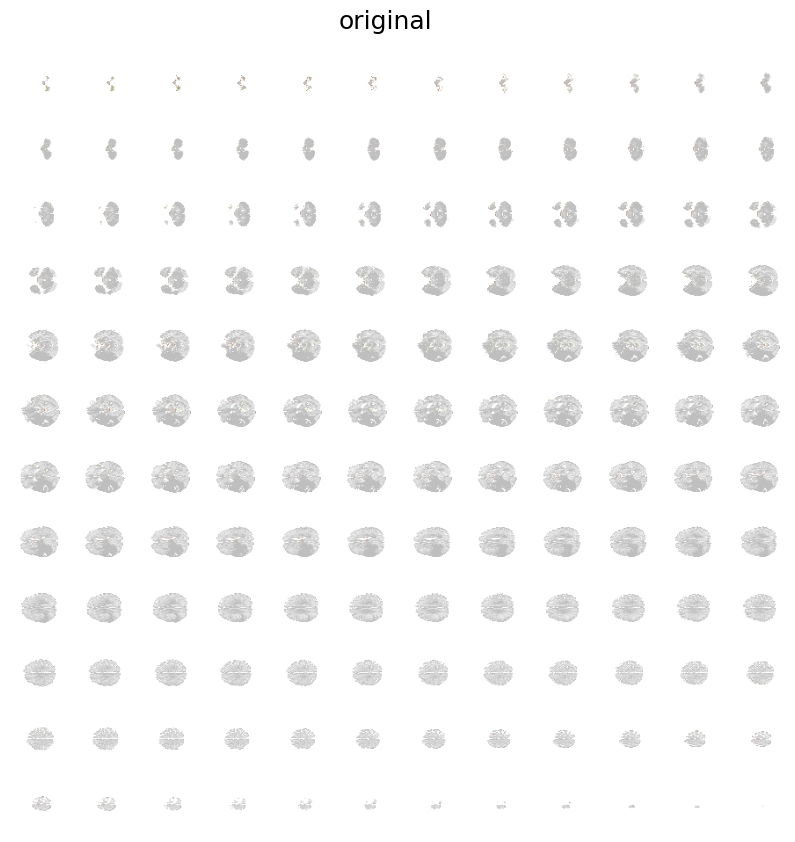

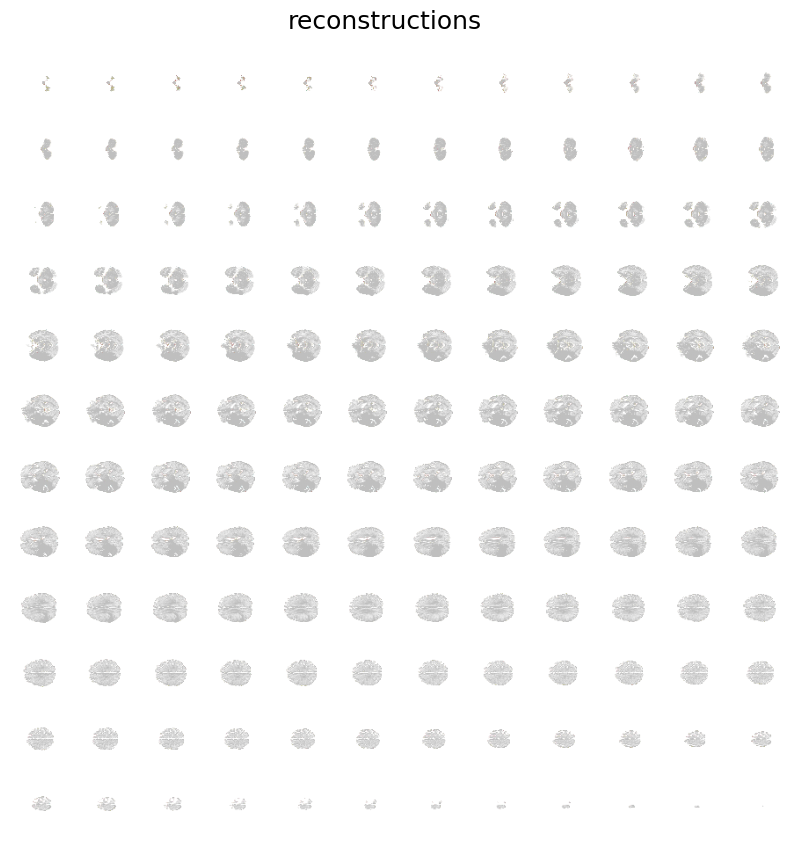

In [47]:
batch = next(gp_dataset)
reconstruct(model, params, batch)

In [ ]:
z = jax.random.normal(size=(128, model.z_size))
samples = model.reverse(z)

# Rescale the samples to the range [0, 1]
samples = (samples + 1.0) / 2.0

# Save the samples as an image grid
fig = plt.figure(figsize=(8, 8))
for i in range(16 * 8):
    ax = fig.add_subplot(16, 8, i+1)
    ax.imshow(samples[i], cmap='gray')
    ax.axis('off')
plt.savefig('glow_samples.png')
plt.close(fig)

In [ ]:
interpolate(model, params, batch)

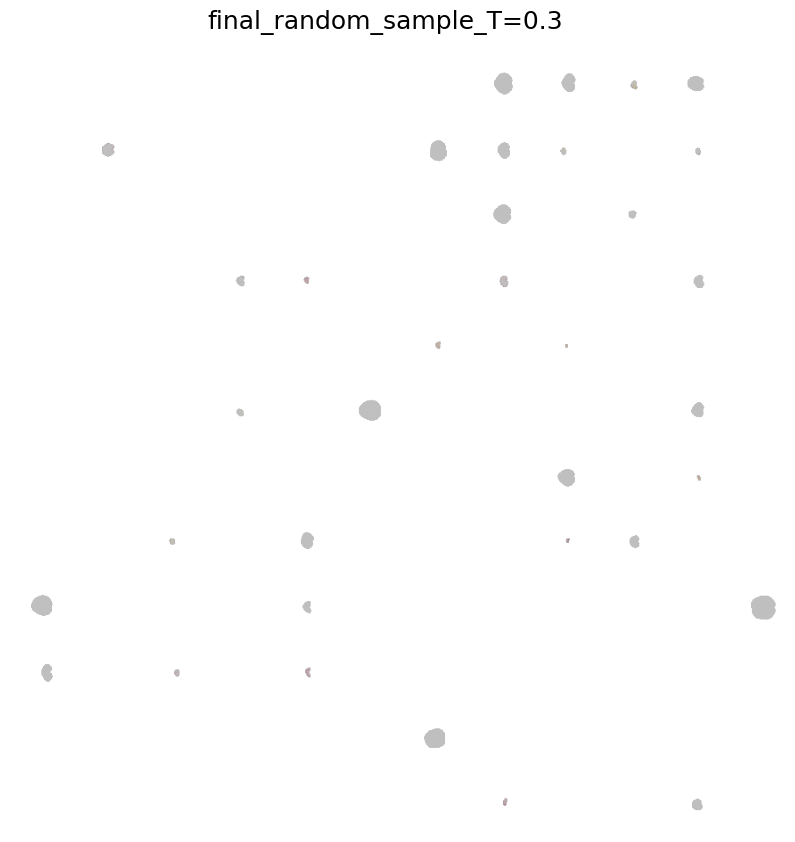

In [40]:
sample(model, params, shape=(155,) + config_dict["sampling_shape"], 
       key=jax.random.PRNGKey(11), sampling_temperature=0.3,
       save_path="samples/final_random_sample_T=0.3.png");

In [ ]:
y = sample(model, params, shape=(40,) + config_dict["sampling_shape"], 
       key=jax.random.PRNGKey(11), sampling_temperature=0.5,
       save_path="samples/final_random_sample_T=0.5.png");
save_path = "output/validation_image" + f"_1.npy"
np.save(save_path, y)

In [ ]:
output=np.load("/dhc/home/youngbin.ko/glow_brain/model/output/validation_image_1.npy")
output.shape

In [ ]:
li_imgs = [np.asarray(Image.open(f)) for f in sorted(glob.glob("results/lin_int_*.png"))]
wandb.log({"Linear Interpolation": [wandb.Image(img) for img in li_imgs]})

In [48]:
x, z, logdets, priors = model.apply(params, batch, reverse=False)
rec, *_ = model.apply(params, z[-1], z=z, reverse=True)

/dhc/home/youngbin.ko/conda3/envs/exp_glow/lib/python3.10/site-packages/flax/core/scope.py:740: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  abs_value_flat = jax.tree_leaves(abs_value)
/dhc/home/youngbin.ko/conda3/envs/exp_glow/lib/python3.10/site-packages/flax/core/scope.py:741: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  value_flat = jax.tree_leaves(value)


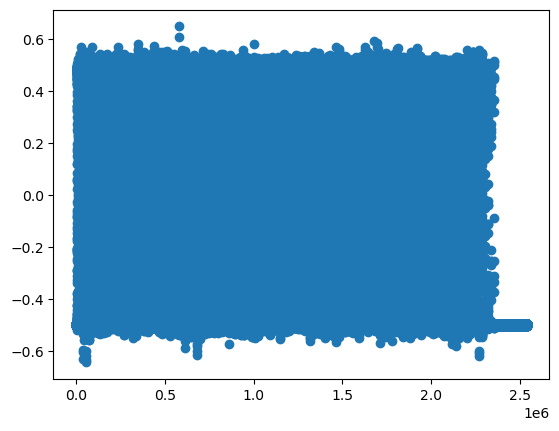

In [49]:
samples = rec.reshape(-1)
plt.scatter(jnp.arange(len(samples)), samples)
plt.show()

In [50]:
rec.shape

(155, 64, 64, 4)

/dhc/home/youngbin.ko/conda3/envs/exp_glow/lib/python3.10/site-packages/flax/core/scope.py:740: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  abs_value_flat = jax.tree_leaves(abs_value)
/dhc/home/youngbin.ko/conda3/envs/exp_glow/lib/python3.10/site-packages/flax/core/scope.py:741: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  value_flat = jax.tree_leaves(value)


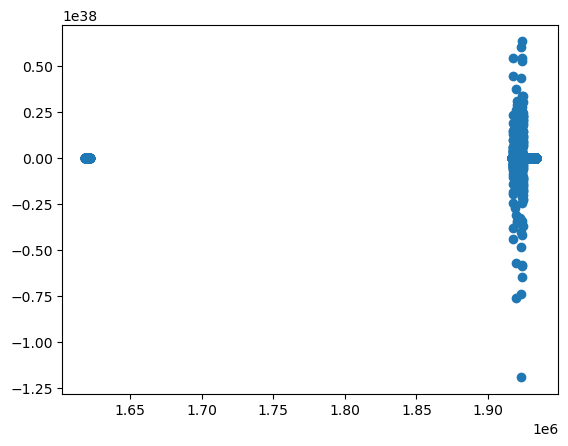

In [52]:
# Generate some samples using the model
new_z2 = np.random.normal(size=z[2].shape)
new_z1 = np.random.normal(size=z[1].shape)
new_z0 = np.random.normal(size=z[0].shape)
rec, *_ = model.apply(params, new_z2, z=[new_z0,new_z1,new_z2], reverse=True)

# Flatten the samples into a 1D array
samples = rec.reshape(-1)

# Plot a scatter plot of the samples to see if they look Gaussian
plt.scatter(jnp.arange(len(samples)), samples)
plt.show()


In [56]:
noise = np.random.normal(size=(155, 64, 64, 4)) #generates gaussian noise

log_likelihood_noise = get_logpz(noise,[None])
log_likelihood_noise = jnp.mean(log_likelihood_noise)

#log_likelihood_validation = get_logpz(model.apply(#one batch val))
print(log_likelihood_noise)
#print(f'Log-likelihood of noise: {log_likelihood_noise:.2f}')
#print(f'Log-likelihood of validation set: {log_likelihood_validation:.2f}')

-364.02402


In [57]:
x, z, logdets, priors = model.apply(params, batch, reverse=False)
log_likelihood_validation = jnp.mean(get_logpz(z,priors))

print(log_likelihood_validation)

-100.86181


In [ ]:
#1. scatter(Val_output[:,1], Val_output[:,2], ...)
#use model output from validation

#2. 0.5/batch_size*norm(Y)^2